# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# When using Google Colab we want to mount the data drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except:
    IN_COLAB = False


Mounted at /content/drive


In [2]:
# When using Google Colab we want copy the Kaggle API key and check kaggle version
if IN_COLAB:
    !cp -Rv /content/drive/MyDrive/workspace/arvato_data/.kaggle ~/ && chmod 600 ~/.kaggle/kaggle.json

'/content/drive/MyDrive/workspace/arvato_data/.kaggle' -> '/root/.kaggle'
'/content/drive/MyDrive/workspace/arvato_data/.kaggle/kaggle.json' -> '/root/.kaggle/kaggle.json'


In [3]:
kg_version = !pip show kaggle | grep Version
kg_version = kg_version[0].split()[1].split('.')
kg_version

['1', '5', '12']

In [4]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import gc

from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score

# modeling 
import lightgbm as lgb

# if kaggle API version greater than 1.5.0 load kaggle API:
if int(kg_version[1]) == 5 and int(kg_version[2]) > 0:
    from kaggle.api.kaggle_api_extended import KaggleApi
    kg_loaded = True
else:
    kg_loaded = False
    print("Kaggle module must be upgraded!")

# magic word for producing visualizations in notebook
%matplotlib inline

# Google Colab environment:
if IN_COLAB:
    # Get pandas version
    print("Pandas verion: ", pd.__version__)

Pandas verion:  1.1.5


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Strategy for exploring the data:

* Load datasets. Initially load random samples, finally load the full datasets.
* Load excel information files.
* Get the attributes from excel files and compare them to the attributes apearing the datasets.
* Get the value pools for each known attribute in the excel files and check against the values for each attribute in the datasets.
* Replace the values outside the pools with NaNs.
* Replace values in the pools representing unknowns, missing, not given, etc. with NaNs.
* Explore NaNs, analysing and understanding missing values in the two datasets.
* Identify significance of categorical, ordinal attributes.

### Load data and excel files

In [5]:
# Assign path names to variables for easier manipulation later on.

azdias_file = "/content/drive/MyDrive/workspace/arvato_data/Udacity_AZDIAS_052018.csv" if IN_COLAB else "../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv"
customers_file = "/content/drive/MyDrive/workspace/arvato_data/Udacity_CUSTOMERS_052018.csv" if IN_COLAB else "../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv"
mailout_train_file = "/content/drive/MyDrive/workspace/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv" if IN_COLAB else "../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv"
mailout_test_file = "/content/drive/MyDrive/workspace/arvato_data/Udacity_MAILOUT_052018_TEST.csv" if IN_COLAB else "../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv"

# Files with information about the columns depicted in the csv files
dias_attrib = "/content/drive/MyDrive/workspace/arvato_data/DIAS Attributes - Values 2017.xlsx" if IN_COLAB else "DIAS Attributes - Values 2017.xlsx"
dias_info = "/content/drive/MyDrive/workspace/arvato_data/DIAS Information Levels - Attributes 2017.xlsx" if IN_COLAB else "DIAS Information Levels - Attributes 2017.xlsx"

# Kaggle submission file
kg_submission = "/content/drive/MyDrive/workspace/arvato_data/" if IN_COLAB else ""
# Kaggle competition
kg_competition = 'udacity-arvato-identify-customers'

We will create a function to load a sample of the datasets to speed things up during the data exploration phase particularly for the larger azdias dataset. This will reduce the memory used for holding the whole dataset initially, but also greatly improve the speed of calculations when exploring and cleaning the data. We will later use the whole dataset for best results.


In [6]:
def get_df_sample(n_samples, seed=None, *args, **kwargs):
    """Load a random sample out of an input csv file or the whole file.

    Args:
        n_samples (int): Size of sample (number of rows) to randomly load from the input file.
        args, kwargs: Pass arguments and keword arguments as in pandas `read_csv` method.
        Ref: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

    Returns:
        The dataframe loaded from the input file of n_samples rows
    
    Reference:
        Stack Overflow - `Read a small random sample from a big CSV file into a Python data frame`:
        https://stackoverflow.com/a/61631765/10074873
        Pandas - `Iterating through files chunk by chunk`:
        https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#iterating-through-files-chunk-by-chunk
        Numpy - `Random Generator`:
        https://numpy.org/doc/stable/reference/random/generator.html#random-generator
    """
    rng = np.random.default_rng(seed=seed)

    samples_reader = pd.read_csv(*args, **kwargs)
    df = samples_reader.get_chunk(n_samples)

    for chunk in samples_reader:
        chunk.index = rng.integers(n_samples, size=len(chunk))
        df.loc[chunk.index] = chunk
    
    return df


* Read first the attributes as strings, to get the categories and then use that to read them directly as categorical.

In [7]:
# Set to `True` to go through all the cells.
RUN_ALL = False

In [8]:
if RUN_ALL:
    # Try loading a sample
    azdias_try1 = get_df_sample(200000, 42, azdias_file, sep=';', chunksize=256000)

    azdias_try1.head()

In [9]:
if RUN_ALL:
    # Check the types of columns
    azdias_try1.dtypes.value_counts()

In [10]:
if RUN_ALL:
    # Check `object` columns
    azdias_try1.select_dtypes(include=object).head()

####Check columns 18, 19 that produced warnings when reading csv data

In [11]:
if RUN_ALL:
    # Check the two columns to identify why pandas "complained" about mixed types
    azdias_try1_1819 = azdias_try1.iloc[:,[18, 19]]

    azdias_try1_1819.columns

The two attributes are `'CAMEO_DEUG_2015', 'CAMEO_INTL_2015'`. We should check their values range to further explore them.

In [12]:
if RUN_ALL:
    azdias_try1_1819.CAMEO_DEUG_2015.unique(), azdias_try1_1819.CAMEO_INTL_2015.unique()

In [13]:
if RUN_ALL:
    # Clean up
    del azdias_try1, azdias_try1_1819

In these columns there are two values `X` and `XX` respectively that fall outside the range of values for this attributes as seen in `DIAS Attributes - Values 2017.xlsx`.

#### Importing values as NaNs at loading with `read_csv`

By observing the helper files `DIAS Attributes - Values 2017.xlsx` and `DIAS Information Levels - Attributes 2017.xlsx` we can see that zeros (`0` or `0.0`) and `-1` (`-1` or `-1.0`) values may be converted to NaNs as they offer no information even in the fields that are considered as valid input. `na_values` argument of `read_csv` method will be used for this to do this conversion during data import. This will leave the value `9` that is considered as `unkown` in some variables to be processed later.

We will take advantage of the `na_values` argument in `read_csv`method to pass a tuple of values that will:

* convert specific values to NaNs
* allow auto importing of attributes that were mixed types as specific types (numerical).

We will also use `parse_dates` argument to import attribute `EINGEFUEGT_AM` as datetime.

There are there more categorical attributes (`'CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'`) that we can identify which will be converted later on.

We will initially use samples of the supplied datasets to be able to explore the data and perform all necessary computations faster, preventing notebook crashes due to insufficient memory.

A samle of 200,000 rows will be used for `AZDIAS` and 150,000 rows for `CUSTOMERS` datasets to keep a relative balance between the two datasets.

In [14]:
azd_sample_size = 200000
cus_sample_size = 150000

# Specific values to replace as np.NaN while loading the dataframe.
na_tupl = (-1, -1.0, 0, 0.0, 'X', 'XX')

# `read_csv` parameters dictionary
read_csv_kwargs = {
    'sep': ';',
    'na_values': na_tupl,
    'chunksize': 256000,
    'parse_dates': ['EINGEFUEGT_AM'],
}

# Read samples from azdias, customers datasets of size n rows, (use parse_dates to convert `EINGEFUEGT_AM` to datetime).
azdias = get_df_sample(azd_sample_size, 42, azdias_file, **read_csv_kwargs)
# custrs = pd.read_csv(customers_file, sep=';', na_values=na_tupl, parse_dates=['EINGEFUEGT_AM'])
custrs = get_df_sample(cus_sample_size, 42, customers_file, **read_csv_kwargs)

Let us check the dataframes now:

In [15]:
azdias.shape, custrs.shape

((200000, 366), (150000, 369))

In [16]:
azdias.sample(7)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
34460,734700,NaN,1.0,17.0,16.0,16.0,NaN,NaN,16.0,1.0,NaN,2.0,2.0,1.0,NaN,1.0,7.0,4A,4.0,22.0,2.0,3.0,4.0,4.0,3.0,1.0,1.0,3.0,NaN,NaN,9,6.0,NaN,NaN,10,9,NaN,NaN,5.0,6.0,...,5.0,1.0,2.0,4.0,3.0,4.0,4,6,2,5,4,3,4,2,5,4,3,3,3,5,2.0,NaN,1.0,NaN,5.0,5.0,NaN,NaN,1.0,NaN,2.0,3.0,6.0,3.0,1.0,9.0,7.0,4,2,3
6323,713914,NaN,9.0,15.0,NaN,NaN,NaN,NaN,20.0,1.0,NaN,NaN,3.0,1.0,NaN,3.0,7.0,3B,3.0,23.0,5.0,4.0,5.0,4.0,3.0,2.0,3.0,4.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,NaN,6.0,...,NaN,3.0,1.0,4.0,5.0,4.0,4,4,7,1,4,7,2,5,4,4,7,7,5,7,1.0,NaN,1.0,NaN,5.0,5.0,1.0,NaN,2.0,NaN,NaN,3.0,6.0,5.0,6.0,9.0,7.0,1,1,1
179395,203101,NaN,9.0,12.0,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,1.0,27.0,NaN,4.0,1.0,9B,9.0,51.0,5.0,5.0,3.0,3.0,2.0,3.0,3.0,3.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,NaN,NaN,...,2.0,3.0,3.0,2.0,1.0,1.0,6,7,3,6,6,2,7,2,3,3,1,2,3,2,3.0,NaN,3.0,NaN,5.0,2.0,NaN,2.0,2.0,NaN,2.0,10.0,11.0,8.0,6.0,9.0,3.0,3,2,4
61734,381240,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,2.0,9.0,NaN,4.0,6.0,6E,6.0,45.0,2.0,5.0,2.0,1.0,5.0,5.0,5.0,4.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,NaN,NaN,...,NaN,3.0,3.0,1.0,4.0,1.0,5,7,4,6,6,1,4,1,4,2,2,5,4,4,1.0,NaN,3.0,NaN,1.0,5.0,NaN,NaN,2.0,NaN,NaN,7.0,8.0,5.0,6.0,9.0,3.0,4,2,4
89481,714038,NaN,1.0,18.0,NaN,NaN,NaN,NaN,18.0,5.0,NaN,NaN,2.0,4.0,NaN,3.0,5.0,8A,8.0,51.0,1.0,1.0,4.0,5.0,2.0,3.0,1.0,2.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,NaN,NaN,...,3.0,3.0,1.0,5.0,1.0,4.0,6,6,2,5,7,1,6,5,5,4,3,2,2,2,2.0,NaN,2.0,NaN,4.0,4.0,NaN,NaN,2.0,NaN,4.0,9.0,12.0,9.0,3.0,9.0,7.0,5,2,3
115073,999960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,4.0,5.0,NaN,6,3,6,6,7,3,5,5,5,4,7,2,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
160597,765288,2.0,1.0,12.0,NaN,NaN,NaN,NaN,12.0,2.0,NaN,NaN,1.0,2.0,NaN,1.0,2.0,1E,1.0,15.0,5.0,5.0,3.0,2.0,3.0,4.0,4.0,5.0,NaN,1.0,7,5.0,NaN,NaN,10,7,NaN,NaN,NaN,NaN,...,1.0,1.0,3.0,2.0,4.0,3.0,5,7,1,6,7,1,7,1,2,2,2,5,3,4,3.0,NaN,3.0,NaN,1.0,4.0,NaN,3.0,2.0,NaN,4.0,9.0,10.0,7.0,6.0,9.0,1.0,3,2,4


In [17]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: datetime64[ns](1), float64(320), int64(42), object(3)
memory usage: 558.5+ MB


In [18]:
custrs.sample(7)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
21314,183678,NaN,1.0,21.0,16.0,NaN,NaN,NaN,15.0,1.0,NaN,1.0,3.0,1.0,NaN,2.0,7.0,3B,3.0,23.0,3.0,1.0,2.0,2.0,5.0,4.0,4.0,5.0,NaN,NaN,9,NaN,NaN,NaN,10,9,NaN,6.0,1.0,6.0,...,4.0,4.0,5.0,2,4,6,3,3,5,4,6,4,5,4,6,4,5,1.0,NaN,1.0,NaN,5.0,5.0,NaN,NaN,1.0,NaN,NaN,3.0,5.0,4.0,1.0,9.0,8.0,2,FOOD,SINGLE_BUYER,NaN,1,3
144168,179789,2.0,1.0,7.0,NaN,NaN,NaN,NaN,7.0,8.0,NaN,NaN,1.0,9.0,NaN,2.0,6.0,6E,6.0,45.0,2.0,5.0,2.0,1.0,5.0,5.0,5.0,5.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,NaN,6.0,...,2.0,5.0,2.0,5,7,1,5,6,1,5,1,1,2,1,2,1,2,1.0,NaN,2.0,NaN,1.0,5.0,NaN,NaN,1.0,1.0,3.0,4.0,2.0,1.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,NaN,2,4
89544,55552,1.0,1.0,18.0,NaN,NaN,NaN,NaN,12.0,1.0,NaN,NaN,4.0,1.0,NaN,3.0,4.0,7A,7.0,41.0,4.0,4.0,3.0,2.0,3.0,2.0,4.0,4.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,NaN,6.0,...,1.0,5.0,1.0,7,6,1,7,4,3,4,2,3,4,1,1,3,4,3.0,NaN,3.0,NaN,2.0,5.0,NaN,3.0,1.0,NaN,2.0,3.0,6.0,5.0,2.0,9.0,2.0,1,FOOD,SINGLE_BUYER,NaN,2,3
34556,59891,NaN,1.0,NaN,NaN,NaN,NaN,NaN,15.0,2.0,NaN,NaN,2.0,2.0,NaN,3.0,3.0,2D,2.0,14.0,6.0,1.0,3.0,3.0,3.0,4.0,3.0,3.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,7.0,6.0,...,2.0,5.0,4.0,7,6,3,7,6,3,6,3,3,4,3,4,3,4,2.0,1.0,3.0,NaN,5.0,5.0,NaN,3.0,2.0,1.0,3.0,4.0,5.0,4.0,4.0,9.0,4.0,2,COSMETIC,SINGLE_BUYER,NaN,2,3
23152,34696,NaN,1.0,17.0,6.0,NaN,NaN,NaN,17.0,1.0,NaN,1.0,3.0,1.0,NaN,3.0,6.0,1D,1.0,15.0,3.0,1.0,5.0,4.0,2.0,2.0,4.0,5.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,NaN,3.0,...,3.0,4.0,4.0,4,7,3,6,4,1,5,1,2,2,2,2,1,2,1.0,NaN,3.0,NaN,2.0,5.0,1.0,23.0,2.0,NaN,3.0,1.0,2.0,1.0,1.0,9.0,7.0,4,COSMETIC,SINGLE_BUYER,NaN,2,4
19163,71819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,NaN,NaN,...,4.0,5.0,NaN,6,3,6,6,7,3,5,5,5,4,7,2,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,FOOD,SINGLE_BUYER,NaN,2,1
14491,13495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,NaN,NaN,...,4.0,5.0,NaN,6,3,6,6,7,3,5,5,5,4,7,2,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,COSMETIC_AND_FOOD,MULTI_BUYER,NaN,2,2


In [19]:
custrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: datetime64[ns](1), float64(321), int64(42), object(5)
memory usage: 422.3+ MB


So, in `custrs` dataset the three extra columns (`'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'`) are imported as one `float64` and two `object` dtypes, comparing to `azdias` columns.

In [20]:
azd_obj_cols = azdias.select_dtypes(include=object)

azd_obj_cols.head()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
0,5B,D19_SONSTIGE,W
1,8A,D19_UNBEKANNT,W
2,5B,NaN,W
3,7B,D19_UNBEKANNT,W
4,8B,D19_UNBEKANNT,W


In [21]:
cus_obj_cols = custrs.select_dtypes(include=object)

cus_obj_cols.head()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,NaN,NaN,NaN,FOOD,SINGLE_BUYER
1,7A,D19_SONSTIGE,W,FOOD,SINGLE_BUYER
2,NaN,NaN,NaN,FOOD,SINGLE_BUYER
3,4C,D19_NAHRUNGSERGAENZUNG,W,COSMETIC,MULTI_BUYER
4,7B,D19_SCHUHE,W,FOOD,MULTI_BUYER


Convert the remaining **object** columns (`'CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ', etc.`) to **categorical**:

In [22]:
# Get the names of the columns to convert
azd_cat_cols = azd_obj_cols.columns.tolist()
cus_cat_cols = cus_obj_cols.columns.tolist()
# Convert all three columns using astype method
azdias[azd_cat_cols] = azdias[azd_cat_cols].astype('category')
custrs[cus_cat_cols] = custrs[cus_cat_cols].astype('category')

azdias[azd_cat_cols].dtypes

CAMEO_DEU_2015              category
D19_LETZTER_KAUF_BRANCHE    category
OST_WEST_KZ                 category
dtype: object

## Explore attributes in the dataset(s) and excel files

### 1. Compare atributes between the two excel files

Read in the excel files with attributes related information

In [23]:
# Read in the mapping of data values for each feature in the DIAS dataset.
attr_cols = range(1,5)  # skip the first column as it is empty
dfdias_attrib = pd.read_excel(dias_attrib, header=1, usecols=attr_cols)
dfdias_attrib.head(7)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years


In [24]:
# DIAS Information Levels - Attributes 2017.xlsx
dfdias_info = pd.read_excel(dias_info, header=1, usecols=attr_cols)
dfdias_info.head(7)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN


In [25]:
# Get attributes' names from the Attribute column in the two excel files

# `DIAS Information Levels - Attributes 2017.xlsx`
dfdias_info_attrs = dfdias_info.Attribute.value_counts().index.values

# `DIAS Attributes - Values 2017.xlsx`
attrbf_names = dfdias_attrib.Attribute.value_counts().index.values

# Get the attribute names from `azdias` df columns:
azd_attr_names = azdias.columns.values

# Get the attribute names from `custrs` df columns:
cus_attr_names = custrs.columns.values

dfdias_info_attrs.size, attrbf_names.size, azd_attr_names.size, cus_attr_names.size

(313, 314, 366, 369)

In [26]:
# Get the set intersetion of the two arrays:
# We are comparing names as they were originaly written in the files.
xcl_attr_intersc = np.intersect1d(attrbf_names, dfdias_info_attrs)

xcl_attr_intersc.size

300

In [27]:
# Attributes values excel file contains some different attributes compared to information excel file:
xcl_attr_diff_vals_info = np.setdiff1d(attrbf_names, dfdias_info_attrs)

xcl_attr_diff_vals_info, xcl_attr_diff_vals_info.size

(array(['BIP_FLAG', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
        'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_LOTTO_RZ',
        'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_VERSAND_ANZ_12',
        'D19_VERSAND_ANZ_24', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
        'KBA13_CCM_3000', 'KBA13_CCM_3001'], dtype=object), 14)

In [28]:
# Information excel file contains some different attributes compared to attributes excel file:
xcl_attr_diff_info_vals = np.setdiff1d(dfdias_info_attrs, attrbf_names)

xcl_attr_diff_info_vals, xcl_attr_diff_info_vals.size

(array(['ARBEIT', 'D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24',
        'D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24',
        'D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24',
        'D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24',
        'D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24',
        'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
        'D19_VERSI_ONLINE_DATUM', 'EINWOHNER', 'GKZ', 'PLZ', 'PLZ8'],
       dtype=object), 13)

Taking the symmetric difference of the attributes in excel files, we can observe that there are more common attributes, but we must perform some string operations to bring them in similar forms for comparison.

In [29]:
# Symmetric difference of the two attributes' sets.
xcl_attrs_symtrc_diff = np.union1d(xcl_attr_diff_vals_info, xcl_attr_diff_info_vals)

xcl_attrs_symtrc_diff, xcl_attrs_symtrc_diff.size

(array(['ARBEIT', 'BIP_FLAG',
        'D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24',
        'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_GESAMT_ANZ_12',
        'D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24',
        'D19_GESAMT_ANZ_24', 'D19_LOTTO_RZ',
        'D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24',
        'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
        'D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24',
        'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24',
        'D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24',
        'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_DATUM',
        'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'EINWOHNER',
        'GKZ', 'KBA13_CCM_3000', 'KBA13_CCM_3001', 'PLZ', 'PLZ8'],
       dtype=object), 27)

We will fix the names of the attributes that seem different in the `DIAS Information Levels - Attributes 2017.xlsx` (or info) file.

* Parse lines containing more than one attribute

In [30]:
# We will create a new list splitting the lines containing more than one attribute and stripping white space:
xcl_attr_diff_info_vals_fxd = [i.strip() for x in xcl_attr_diff_info_vals for i in x.split("  ", maxsplit=1)]

xcl_attr_diff_info_vals_fxd, len(xcl_attr_diff_info_vals_fxd)

(['ARBEIT',
  'D19_BANKEN_ ANZ_12',
  'D19_BANKEN_ ANZ_24',
  'D19_GESAMT_ANZ_12',
  'D19_GESAMT_ANZ_24',
  'D19_TELKO_ ANZ_12',
  'D19_TELKO_ ANZ_24',
  'D19_VERSAND_ ANZ_12',
  'D19_VERSAND_ ANZ_24',
  'D19_VERSI_ ANZ_12',
  'D19_VERSI_ ANZ_24',
  'D19_VERSI_DATUM',
  'D19_VERSI_OFFLINE_DATUM',
  'D19_VERSI_ONLINE_DATUM',
  'EINWOHNER',
  'GKZ',
  'PLZ',
  'PLZ8'],
 18)

* Expand initial attributes list to include the newly identified attributes from above.

In [31]:
# Our initial info attributes' list needs to be expanded to compensate for elements that were packed together.
dfdias_info_attrs_new = []
# Create a deep copy of the clean names list so it may be resused.
attrs_to_append = [i for i in xcl_attr_diff_info_vals_fxd]
# For every element in the imported attributes from information file check against the 
# fixed attribute names list and create a new list including fixed names.
for i in dfdias_info_attrs:
    if i in xcl_attr_diff_info_vals and len(attrs_to_append) > 0:
        for idx, x in enumerate(attrs_to_append):
            if i.startswith(x):
                if len(i) > len(x):
                    dfdias_info_attrs_new.append(''.join(x.split()))
                    dfdias_info_attrs_new.append(''.join(attrs_to_append[idx + 1].split()))
                    del attrs_to_append[idx + 1]
                    del attrs_to_append[idx]
                else:
                    dfdias_info_attrs_new.append(x)
                    del attrs_to_append[idx]
                break
    else:
        # just copy the rest of the elements.
        dfdias_info_attrs_new.append(i)

# Convert to numpy array
dfdias_info_attrs_new = np.array(dfdias_info_attrs_new)

dfdias_info_attrs_new[60:80], dfdias_info_attrs_new.size

(array(['FINANZ_VORSORGER', 'D19_WEIN_FEINKOST_RZ', 'KBA05_MODTEMP',
        'FINANZ_HAUSBAUER', 'KBA05_KRSZUL', 'D19_KK_KUNDENTYP',
        'KBA13_BJ_2008', 'KBA05_SEG5', 'D19_KONSUMTYP', 'MOBI_REGIO',
        'KBA13_KMH_211', 'PLZ8_BAUMAX', 'KBA13_FAB_ASIEN',
        'D19_BANKEN_ONLINE_DATUM', 'REGIOTYP', 'ZABEOTYP', 'KBA05_MAXBJ',
        'D19_GESAMT_DATUM', 'KBA13_KMH_140_210', 'W_KEIT_KIND_HH'],
       dtype='<U27'), 318)

Now that we have fixed the names we can compare the attributes between the two attributes' information files.


In [32]:
# Get the set intersetion of the two arrays:
xcl_attr_intersc_fxd = np.intersect1d(attrbf_names, dfdias_info_attrs_new)

xcl_attr_intersc_fxd.size

310

Common attributes between the two files increased to 310. After this different attributes in each file become as follows:

In [33]:
# DIAS Attributes - Values 2017.xlsx unique values:
xcl_attr_diff_vals_info = np.setdiff1d(attrbf_names, dfdias_info_attrs_new)

xcl_attr_diff_vals_info, xcl_attr_diff_vals_info.size

(array(['BIP_FLAG', 'D19_LOTTO_RZ', 'KBA13_CCM_3000', 'KBA13_CCM_3001'],
       dtype=object), 4)

In [34]:
# DIAS Information Levels - Attributes 2017.xlsx contains some different attributes compared to attributes excel file:
xcl_attr_diff_info_vals = np.setdiff1d(dfdias_info_attrs_new, attrbf_names)

xcl_attr_diff_info_vals, xcl_attr_diff_info_vals.size

(array(['ARBEIT', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
        'D19_VERSI_ONLINE_DATUM', 'EINWOHNER', 'GKZ', 'PLZ', 'PLZ8'],
       dtype='<U27'), 8)

In [35]:
# Symmetric difference of the two attributes' sets.
xcl_attrs_symtrc_diff = np.union1d(xcl_attr_diff_vals_info, xcl_attr_diff_info_vals)

xcl_attrs_symtrc_diff, xcl_attrs_symtrc_diff.size

(array(['ARBEIT', 'BIP_FLAG', 'D19_LOTTO_RZ', 'D19_VERSI_DATUM',
        'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'EINWOHNER',
        'GKZ', 'KBA13_CCM_3000', 'KBA13_CCM_3001', 'PLZ', 'PLZ8'],
       dtype=object), 12)

In [36]:
# Taking the union for the total of unique values in both files together.
xcl_attrs_unique = np.union1d(attrbf_names, dfdias_info_attrs_new)

xcl_attrs_unique.size

322

The two Excel spreadsheets provided in the workspace (`DIAS Information Levels - Attributes 2017.xlsx` and `DIAS Attributes - Values 2017.xlsx`) contain 310 common attributes. In addition the first file contains 8 unique attributes while the second 4 unique attributes. In total there are 322 unique attributes present in both files together.

###Comparing `azdias`, `custrs` datasets to the unique attributes from the two excel files.


In [37]:
attrs_intesc = np.intersect1d(azd_attr_names, xcl_attrs_unique)

azd_attr_names.size, xcl_attrs_unique.size, attrs_intesc.size

(366, 322, 276)

For the customers dataset, they only different attributes should be the 3 extra ones in the customers dataset, so the intersection should be the same as for `azdias` dataset:

In [38]:
attrs_intesc = np.intersect1d(cus_attr_names, xcl_attrs_unique)

cus_attr_names.size, xcl_attrs_unique.size, attrs_intesc.size

(369, 322, 276)

At first look, we see that only 276 attributes are common. To explore what happens with the rest, we will look at the different attributes from the excel files.

In [39]:
# Set difference of excel unique attributes - azdias set attributes will give us the different excel attributes:
difrnt_xcl_attrs = np.setdiff1d(xcl_attrs_unique, azd_attr_names)

difrnt_xcl_attrs, difrnt_xcl_attrs.size

(array(['BIP_FLAG', 'CAMEO_DEUINTL_2015', 'D19_BANKEN_DIREKT_RZ',
        'D19_BANKEN_GROSS_RZ', 'D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_REST_RZ',
        'D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_REST_RZ',
        'D19_BILDUNG_RZ', 'D19_BIO_OEKO_RZ', 'D19_BUCH_RZ',
        'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL_RZ', 'D19_ENERGIE_RZ',
        'D19_FREIZEIT_RZ', 'D19_GARTEN_RZ', 'D19_HANDWERK_RZ',
        'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL_RZ', 'D19_KK_KUNDENTYP',
        'D19_KOSMETIK_RZ', 'D19_LEBENSMITTEL_RZ', 'D19_LOTTO_RZ',
        'D19_NAHRUNGSERGAENZUNG_RZ', 'D19_RATGEBER_RZ', 'D19_REISEN_RZ',
        'D19_SAMMELARTIKEL_RZ', 'D19_SCHUHE_RZ', 'D19_SONSTIGE_RZ',
        'D19_TECHNIK_RZ', 'D19_TELKO_MOBILE_RZ', 'D19_TELKO_REST_RZ',
        'D19_TIERARTIKEL_RZ', 'D19_VERSAND_REST_RZ',
        'D19_VERSICHERUNGEN_RZ', 'D19_VOLLSORTIMENT_RZ',
        'D19_WEIN_FEINKOST_RZ', 'EINWOHNER', 'GEOSCORE_KLS7', 'GKZ',
        'HAUSHALTSSTRUKTUR', 'KBA13_CCM_1400_2500', 'PLZ', 'PLZ8',
        

Examining the `azdias` (and `customers`) columns' names we can observe that most of the above names are not actually missing but have been named slightly different. So, for example `CAMEO_INTL_2015` in azdias dataset is `CAMEO_DEUINTL_2015` in the attributes’ explanations file. This means we have to perform some operations to match the columns that appear different. We can create a dictionary to match old names with the new names, to rename the attributes' from excel files as in the azdias dataset. For most of the columns names with the prefix `D19_` if we remove the suffix `_RZ` we have the desired names.

We can also try to identify the rest of attributes, for example with `FLAG` in name and do the same for the rest, but not for `D19_` as we already know that only the suffix `_RZ` is missing from the name, hence it is seen as differnt string in the code comparisons.

In [40]:
attr_flag = [x for x in azd_attr_names if 'FLAG' in x]
attr_bip = [x for x in azd_attr_names if 'BIP' in x]
attr_soho = [x for x in azd_attr_names if 'SOHO' in x]
attr_kba131400 = [x for x in azd_attr_names if 'KBA13_CCM_14' in x]
attr_geosc =[ x for x in azd_attr_names if 'GEO' in x]
attr_haus = [ x for x in azd_attr_names if 'HAUS' in x]
attr_wach = [ x for x in azd_attr_names if 'WACH' in x]
attr_gkz = [x for x in azd_attr_names if 'GKZ' in x]
attr_plz = [x for x in azd_attr_names if 'PLZ' in x]

attr_flag, attr_bip, attr_soho, attr_kba131400, attr_geosc, \
attr_haus, attr_wach, attr_gkz, attr_plz

(['DSL_FLAG', 'HH_DELTA_FLAG', 'UNGLEICHENN_FLAG'],
 [],
 ['SOHO_KZ'],
 ['KBA13_CCM_1400', 'KBA13_CCM_1401_2500'],
 ['KBA13_PEUGEOT'],
 ['ANZ_HAUSHALTE_AKTIV',
  'ANZ_STATISTISCHE_HAUSHALTE',
  'D19_HAUS_DEKO',
  'FINANZ_HAUSBAUER'],
 [],
 [],
 ['PLZ8_ANTG1',
  'PLZ8_ANTG2',
  'PLZ8_ANTG3',
  'PLZ8_ANTG4',
  'PLZ8_BAUMAX',
  'PLZ8_GBZ',
  'PLZ8_HHZ'])

From the above we see that we also have attributes `'SOHO_KZ', 'KBA13_CCM_1401_2500'` we can match. These matches will greatly reduce the number of different attributes in the azdias dataset when comparing to the attributes' excel files. However, azdias dataset has some more attributes in addition to the ones present in the attributes files.

There are no additional attributes for `GKZ` and `PLZ` or `PLZ8` in azdias dataset.

In [41]:
# Create a dictionary with key: value the old names replacing all `D19_*` names containing `_RZ`
xcl_attr_names_new = {i : i[:-3] if '_RZ' in i else i for i in difrnt_xcl_attrs}
# Replace SOHO_FLAG:
xcl_attr_names_new["SOHO_FLAG"] = 'SOHO_KZ'
# Replace CAMEO_DEUINTL_2015:
xcl_attr_names_new["CAMEO_DEUINTL_2015"] = 'CAMEO_INTL_2015'
# Replace KBA13_CCM_1400_2500:
xcl_attr_names_new["KBA13_CCM_1400_2500"] = 'KBA13_CCM_1401_2500'

xcl_attr_names_new.items()

dict_items([('BIP_FLAG', 'BIP_FLAG'), ('CAMEO_DEUINTL_2015', 'CAMEO_INTL_2015'), ('D19_BANKEN_DIREKT_RZ', 'D19_BANKEN_DIREKT'), ('D19_BANKEN_GROSS_RZ', 'D19_BANKEN_GROSS'), ('D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_LOKAL'), ('D19_BANKEN_REST_RZ', 'D19_BANKEN_REST'), ('D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_GEH'), ('D19_BEKLEIDUNG_REST_RZ', 'D19_BEKLEIDUNG_REST'), ('D19_BILDUNG_RZ', 'D19_BILDUNG'), ('D19_BIO_OEKO_RZ', 'D19_BIO_OEKO'), ('D19_BUCH_RZ', 'D19_BUCH'), ('D19_DIGIT_SERV_RZ', 'D19_DIGIT_SERV'), ('D19_DROGERIEARTIKEL_RZ', 'D19_DROGERIEARTIKEL'), ('D19_ENERGIE_RZ', 'D19_ENERGIE'), ('D19_FREIZEIT_RZ', 'D19_FREIZEIT'), ('D19_GARTEN_RZ', 'D19_GARTEN'), ('D19_HANDWERK_RZ', 'D19_HANDWERK'), ('D19_HAUS_DEKO_RZ', 'D19_HAUS_DEKO'), ('D19_KINDERARTIKEL_RZ', 'D19_KINDERARTIKEL'), ('D19_KK_KUNDENTYP', 'D19_KK_KUNDENTYP'), ('D19_KOSMETIK_RZ', 'D19_KOSMETIK'), ('D19_LEBENSMITTEL_RZ', 'D19_LEBENSMITTEL'), ('D19_LOTTO_RZ', 'D19_LOTTO'), ('D19_NAHRUNGSERGAENZUNG_RZ', 'D19_NAHRUNGSERGAENZUNG'), ('D19_

Let us rename the corresponding attribute names rows as per above dictionary and compare to `azdias` attributes again:

In [42]:
# Create a copy of the `xcl_attrs_unique`
xcl_attrs_unique_new = pd.Series(xcl_attrs_unique)

# Rename specific attributes based on the created dictionary
xcl_attrs_unique_new.replace(xcl_attr_names_new, inplace=True)

# Compare to `azdias` attributes again taking the sets intersection
attrs_common = np.intersect1d(azd_attr_names, xcl_attrs_unique_new)

azd_attr_names.size, xcl_attrs_unique_new.size, attrs_common.size

(366, 322, 312)

There are 312 attributes in `azdias` dataset which are also present in the attributes explanatory excel files. Azdias dataset contains 54 additional attributes:

In [43]:
# Let's see for the attributes' file what are the different attributes according to the previous intersection
azdias_only_attrs = np.setdiff1d(azd_attr_names, xcl_attrs_unique_new)

azdias_only_attrs, azdias_only_attrs.size

(array(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ALTER_KIND1', 'ALTER_KIND2',
        'ALTER_KIND3', 'ALTER_KIND4', 'ANZ_KINDER',
        'ANZ_STATISTISCHE_HAUSHALTE', 'CJT_KATALOGNUTZER', 'CJT_TYP_1',
        'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6',
        'D19_BUCH_CD', 'D19_KONSUMTYP_MAX', 'D19_LETZTER_KAUF_BRANCHE',
        'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12',
        'D19_VERSI_ONLINE_QUOTE_12', 'DSL_FLAG', 'EINGEFUEGT_AM',
        'EINGEZOGENAM_HH_JAHR', 'EXTSEL992', 'FIRMENDICHTE', 'GEMEINDETYP',
        'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3',
        'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_GBZ', 'KBA13_HHZ',
        'KBA13_KMH_210', 'KK_KUNDENTYP', 'KOMBIALTER', 'KONSUMZELLE',
        'LNR', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN',
        'RT_UEBERGROESSE', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG',
        'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A',
        'VK_DISTANZ', 'VK_ZG11'], dtype=obj

And `customers` dataframe has the above plus the three additional columns, as described in the project description.

In [44]:
custrs_only_attrs = np.setdiff1d(cus_attr_names, xcl_attrs_unique_new)

custrs_only_attrs, custrs_only_attrs.size

(array(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ALTER_KIND1', 'ALTER_KIND2',
        'ALTER_KIND3', 'ALTER_KIND4', 'ANZ_KINDER',
        'ANZ_STATISTISCHE_HAUSHALTE', 'CJT_KATALOGNUTZER', 'CJT_TYP_1',
        'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6',
        'CUSTOMER_GROUP', 'D19_BUCH_CD', 'D19_KONSUMTYP_MAX',
        'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES',
        'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12',
        'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992',
        'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1',
        'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX',
        'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210', 'KK_KUNDENTYP',
        'KOMBIALTER', 'KONSUMZELLE', 'LNR', 'MOBI_RASTER',
        'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'RT_KEIN_ANREIZ',
        'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'STRUKTURTYP', 'UMFELD_ALT',
        'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA',


In [45]:
# Attributes unique to excel files.
xcl_only_attrs = np.setdiff1d(xcl_attrs_unique_new, azd_attr_names)

xcl_only_attrs, xcl_only_attrs.size

(array(['BIP_FLAG', 'D19_BUCH', 'D19_KK_KUNDENTYP', 'EINWOHNER',
        'GEOSCORE_KLS7', 'GKZ', 'HAUSHALTSSTRUKTUR', 'PLZ', 'PLZ8',
        'WACHSTUMSGEBIET_NB'], dtype=object), 10)

* `attrs_common` - 312 common attributes between `azdias` dataset and both excel files combined.
* `azdias_only_attrs` - 54 attributes appearing only in `azdias` dataset.
* `xcl_attrs_unique_new` - 322 unique attributes in both excel files combined.
* `xcl_only_attrs` - 10 attributes appearing only in excel files.

For 322 unique attributes present in both excel files combined there are 312 in common with the `azdias` dataset, leaving out 54 attributes known only in `azdias` dataset. Most of these seem to be related to attributes found in the excel files. For example `CJT` attribute in excel files seems to be related to the series of `CJT_TYP_*` attributes in azdias dataset. These are probably derived attributes to allow more granularity of collected information in certain fields.

In [46]:
azdias["CJT_TYP_1"].value_counts()

5.0    60063
2.0    44084
3.0    38364
4.0    36617
1.0    19774
Name: CJT_TYP_1, dtype: int64

###Identify and replace out of range and unkown values with NaNs

We have already made some value replacements when loading the `.csv` files. We observe that some attributes include values outside the pool of values described in the information excel files. These values that are outside the allowed values described in the relevant excel files will be identified and replaced with NaNs. The process we will follow is:

* We will get the allowed values pool for each attribute from the excel file `DIAS Attributes - Values 2017.xlsx`.
* We will create a dictionary, mapping attribute names to value pools.
* We will in turn search the relevant columns in `azdias` and `customers` datasets and replace all the values outside these pools with NaNs.

In addition, there are some special cases where the allowed values are not specified, or the attributes do not have corresponding information in any of the excel files. These will have to be treated case by case.

In [47]:
# In attributes values excel replace NaNs in attribute names with forward fill method ffill
# to make it easier to extract specific attribute names and values
dfdias_attrib_ffil = dfdias_attrib.fillna(method='ffill')

dfdias_attrib_ffil.head(7)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years


1. Create a dictionary with attributes' names as keys and allowed input (`Value` column) as values.

In [48]:
# First get the allowed value ranges per atribute from the attributes values file (DIAS Attributes - Values 2017.xlsx)
# Group by Attribute and get values in a multinex object, then transform to np.ndarray by chaining `values` method:
attrs_values_arr = dfdias_attrib_ffil.groupby("Attribute")["Value"].value_counts().index.values

# Create a helper function to parse values in the form '-1, 0'
def get_nums(x):
    """Return a list of integers from a string
    or the same input if not a string"""
    try:
        li = x.split(',')
        return list(map(int, li))
    except (AttributeError, ValueError):
        return [x]

# Create a dictionary mapping attributes as keys and allowed values in a list to key:[values]
# we are simultaneously injecting np.NaN in values' range as this might already be present
# among the attributes' values in `azdias`.
attrs_val_dict = {}
for i in attrs_values_arr:
    attrs_val_dict.setdefault(i[0],[np.NaN]).extend(get_nums(i[1]))

list(attrs_val_dict.items())[:2]

[('AGER_TYP', [nan, -1, 0, 1, 2, 3]),
 ('ALTERSKATEGORIE_GROB', [nan, 1, 2, 3, 4, 9, -1, 0])]

This dictionary must have its keys (attributes) names match the corresponding attributes names in `azdias` dataset for the cases where the attributes have differences in names, according to the previously created disctionary mapping `xcl_attr_names_new`:

In [49]:
# We will use the `xcl_attr_names_new` to get the corresponding names and create a new dictionary.
attrs_val_pools = {xcl_attr_names_new.get(k, k): v for k, v in attrs_val_dict.items()}

We will create a different dictionary with the special cases with key values equal to `'…'`. These are some special cases where the input is described as "numeric value" which is attribute context related. So, this can be a year, a number typically coded from 1-10, or 1-3, but with the range not exactly specified. This will allow us to process these cases separately.

In [50]:
# Create new dict while removing the related items from the previous
# Iterate through a list of keys 
attrs_val_dict_any = {k: attrs_val_pools.pop(k) for k in list(attrs_val_pools) if '…' in attrs_val_pools[k]}

attrs_val_dict_any

{'ANZ_HAUSHALTE_AKTIV': [nan, '…'],
 'ANZ_HH_TITEL': [nan, '…'],
 'ANZ_PERSONEN': [nan, '…'],
 'ANZ_TITEL': [nan, '…'],
 'GEBURTSJAHR': [nan, '…'],
 'KBA13_ANZAHL_PKW': [nan, '…'],
 'MIN_GEBAEUDEJAHR': [nan, '…']}

We now have two dictionaries mapping attributes to possible values for each attribute. There are some unique attributes (`azdias_only_attrs`) in `azdias` dataset that have not been account for. For these we will adopt the mapping of similar attributes based on context and add them in the first mappings dictionary. We can identify at least two value categories `CJT_*` and `KBA13_` that can be assigned to values' range list `[-1, 0, 1, 2, 3, 4, 5]` as can be observed from similar atributes in excel attributes values file. We cannot do the same for `D19_*` attributes or the any of the rest attributes in the `azdias_only_attrs`.

In [51]:
# we are then left with an undefined values ragne list of attributes for unique to `azdias` as:
azdias_only_attrs_undef = [i for i in azdias_only_attrs if not i.startswith(('CJT_', 'KBA13_'))]

azdias_only_attrs_undef = np.array(azdias_only_attrs_undef)

azdias_only_attrs_undef, azdias_only_attrs_undef.size

(array(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ALTER_KIND1', 'ALTER_KIND2',
        'ALTER_KIND3', 'ALTER_KIND4', 'ANZ_KINDER',
        'ANZ_STATISTISCHE_HAUSHALTE', 'D19_BUCH_CD', 'D19_KONSUMTYP_MAX',
        'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES',
        'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12',
        'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992',
        'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KK_KUNDENTYP',
        'KOMBIALTER', 'KONSUMZELLE', 'LNR', 'MOBI_RASTER',
        'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE',
        'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG',
        'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A', 'VK_DISTANZ',
        'VK_ZG11'], dtype='<U26'), 39)

So, for the `customers` the respective array will be:

In [52]:
cus_only_attrs_undef = np.append(azdias_only_attrs_undef,
                                 ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])

cus_only_attrs_undef, cus_only_attrs_undef.size

(array(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ALTER_KIND1', 'ALTER_KIND2',
        'ALTER_KIND3', 'ALTER_KIND4', 'ANZ_KINDER',
        'ANZ_STATISTISCHE_HAUSHALTE', 'D19_BUCH_CD', 'D19_KONSUMTYP_MAX',
        'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES',
        'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12',
        'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992',
        'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KK_KUNDENTYP',
        'KOMBIALTER', 'KONSUMZELLE', 'LNR', 'MOBI_RASTER',
        'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE',
        'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG',
        'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A', 'VK_DISTANZ',
        'VK_ZG11', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'],
       dtype='<U26'), 42)

* We now have `attrs_val_pools` which is a dictionary mapping of known attribute names and 
lists with accepted values per variable.
* `attrs_val_dict_any` which is a dictionary with attributes' names that do not have specific values defined but instead accept a wider range of numerical values.
* `azdias_only_attrs_undef`, `cus_only_attrs_undef` which are two arrays with all attributes known in `azdias` and `customers` only that do not have associated information about their accepted values.


####Replace unkown and specific values with NaNs

Using the `attrs_val_pools` we can check against the values in respective attributes in `azdias` and `customers` datasets. If values are found outside the accepted ones these will be replaced by NaNs. We will use the keys in this dictionary to iterate trought the attributes and make changes only in the common attributes (`attrs_common`) between `azdias` dataset and excel files.

In [53]:
# for every key (attribute) in the dictionary created earlier
for k in attrs_val_pools:
    # if the attribute is among the common ones
    if k in attrs_common:
        # select all those rows in the column that fall outside the attritbute's
        # specified values pool and replace them with NaN.
        azdias.loc[~azdias[k].isin(attrs_val_pools[k]), k] = np.NaN
        custrs.loc[~custrs[k].isin(attrs_val_pools[k]), k] = np.NaN

azdias['CAMEO_DEUG_2015'].value_counts()

8.0    30385
9.0    24434
6.0    23853
4.0    23414
3.0    19315
2.0    18528
7.0    17556
5.0    12205
1.0     8006
Name: CAMEO_DEUG_2015, dtype: int64

We want to find the attributes where 9 is used for unkown/NaN values, to replace it in `azdias`, `custrs` datasets with NaNs.

In [54]:
# We will use the forward fiiled attribute dataframe to make it easier to extract the attributes' names
attrs_nine_name = dfdias_attrib_ffil[dfdias_attrib_ffil["Value"] == '-1, 9']["Attribute"].tolist()

# Create a dict to use as input for the pandas replace method
replace9_nan_dict = {k:9 for k in attrs_nine_name}
# Add 'KOMBIALTER' attribute in the dict that is not in excel files
replace9_nan_dict['KOMBIALTER'] = 9

# We can now use this dictionary of attributes to replace value 9 (unknown) with
# NaN for specifc attributes in the azdias, custrs dataframe
azdias.replace(replace9_nan_dict, np.NaN, inplace=True)
custrs.replace(replace9_nan_dict, np.NaN, inplace=True)

Special cases where values' pool was `'…'`:

* `ANZ_HAUSHALTE_AKTIV` - number of households in the building numeric value, typically coded from 1-10 but higher values can be accepted (large building blocks)
* `ANZ_HH_TITEL` - number of academic title holder in building, numeric value typically coded from 1-10 but higher values can be accepted (large building blocks)
* `ANZ_PERSONEN` - number of adult persons in the household, numeric value typically coded from 1-3 but higher values can be accepted depending on the area and family size. This has some extreme values values in the range [23, 45] that may be proven outliers.
* `ANZ_TITEL` - number of professional title holder in household, numeric value typically coded from 1-10 but higher values can be accepted depending on the family size.
* `GEBURTSJAHR` - year of birth, with values ranging from 1900 to 2017.
* `KBA13_ANZAHL_PKW` - number of cars in the PLZ8, numeric value. This may also have a large range based on the area (postcode) rural, urban areas.
* `MIN_GEBAEUDEJAHR` - year the building was first mentioned in the database, numeric values of years ranging from 1985 to 2016.

By observation these attributes seem to have acceptable values related to their context.

For the attributes known only to `azdias` dataset that cannot be related to existing information from the excel files there is a number of atributes that appear to be related to one another - `'ALTERSKATEGORIE_FEIN', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4'` - and by context might provide categorization for number of children for age group bins. From `ALTERSKATEGORIE_FEIN` we can understand that there are 25 bins that correspond to an age range. `ANZ_KINDER` provides the number of children, while `''ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4'`, must provide the ages for the 1st, 2nd, 3rd and 4th child. `ANZ_STATISTISCHE_HAUSHALTE` seem to provide some budget categorization in a range 1 - 449 with mean 7.6.

`'D19_BUCH_CD'` is probably related to books and or CDs ownership, `'D19_KONSUMTYP_MAX'` is a categorization of consumer type,`'D19_LETZTER_KAUF_BRANCHE'` provides a categorization based on recent products purchases, `'D19_SOZIALES'` probably provides a social type related categorization, `'D19_TELKO_ONLINE_QUOTE_12'` (few records) is telecoms related probably for the last 12 months average spending, `'D19_VERSI_ONLINE_QUOTE_12'` (few records) is another 12 months spending record, `'DSL_FLAG'` is probably internet line capacity related (DSL line) indicating if person has DSL (value 1), `'EINGEFUEGT_AM'` is probably the date and time the database entry for this entry was inserted (all times are set to 00:00:00), `'EINGEZOGENAM HH JAHR'` is possibly the year someone moved to a household, `'EXTSEL992'` is some kind of age related attribute, `'FIRMENDICHTE'` is a company size categorization probably related to the company each person works for, `'GEMEINDETYP'` is a community type categorization, `'HH_DELTA_FLAG'` cannot be associated with something known, `'KK_KUNDENTYP'` is a customer type categorization, `'KOMBIALTER'` is another age related categorization, `'KONSUMZELLE'` is another flag probably indicating somekind of consumer feature, `'MOBI_RASTER'` should be an attribute related to mobiles (or mobility) range 1-6, `'RT_KEIN_ANREIZ'` refers lack of incentives on something with values range 1-5, `'RT_SCHNAEPPCHEN'` describes bargain response on something with values range 1-5, `'RT_UEBERGROESSE'` describes over-size response on something with values range 1-5, `'SOHO_KZ'` could be related to small office / home office binary attribute, `'STRUKTURTYP'` provides structure type for homes (?) with values range 1-3, `'UMFELD_ALT'` records old relatives(?) with values range 1-5, `'UMFELD_JUNG'` records young relatives with values range 1-5, `'UNGLEICHENN_FLAG'` binary attribute recording unequality, `'VERDICHTUNGSRAUM'` probably describes the density of the living area (neibourhood, block?) values 1-45, `'VHA', 'VHN', 'VK_DHT4A', 'VK_DISTANZ','VK_ZG11'` cannot be identified.

In [55]:
# Based on the above these are additional categoricals:
extra_cat_cols = np.array(['ALTERSKATEGORIE_FEIN', 'D19_BUCH_CD', 'D19_KONSUMTYP_MAX',
                          'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12',
                          'FIRMENDICHTE', 'GEMEINDETYP', 'KK_KUNDENTYP', 'KOMBIALTER',
                          'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN',
                          'RT_UEBERGROESSE', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG',
                          'KONSUMZELLE', 'SOHO_KZ', 'UNGLEICHENN_FLAG', 'VHA', 'VHN',
                          'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11'])
# ('KOMBIALTER' needs to remove 9 as NaN)

All known categorical (includes all ordinal) attributes `cat_attrs`:

In [56]:
cat_attrs = np.union1d(attrs_common, extra_cat_cols)

cat_attrs.size

336

##Analysing and understanding missing values in `azdias` and `custrs` dfs

* Total NaNs:

In [57]:
# count NaNs in the dataframes
azdias_nan = azdias.isna().sum().sum()
cus_df_nan = custrs.isna().sum().sum()

(azdias.size, azdias_nan, round(azdias_nan/azdias.size, 2)), \
(custrs.size, cus_df_nan, round(cus_df_nan/custrs.size, 2))

((73200000, 20481334, 0.28), (55350000, 19665551, 0.36))

There are about 28% NaNs in `azdias` df and about 35-36% NaNs in the `customers` 
dataset out of the total data sizes.

* NaNs per column:

In [58]:
def cols_nans_info(df, cols=None):
    """Return a new dataframe with NaNs summary per column of the input df

    Creates and returns a new dataframe with three columns that correspond to
    the attributes (columns) of the initial dataframe, the NaN counts per column
    and portion of NaNs per column.

    Args:
        df (pd.DataFrame): The input dataframe to process.
        cols (tuple): 3 elements tuple with the names of the three columns in the
        output dataframe. If left None the three default names ('Columns',
        'NaNcounts', 'NaNportions') will be used.
    
    Returns:
        A new dataframe with three columns providing counts and portions of NaNs
        per column in the input df. Examle:

            Columns	     NaNcounts	NaNportions
        0	AGER_TYP	   685843	    0.769554
        1	AKT_DAT_KL     73499	    0.082470
        2	ALTER_HH	   310267	    0.348137
        3	ALTER_KIND1	   810163	    0.909048
        4	ALTER_KIND2	   861722	    0.966900
    """
    cols = cols or ('Columns', 'NaNcounts', 'NaNportions')
    new_df = df.isna().sum().rename_axis(cols[0]).reset_index(name=cols[1])
    new_df[cols[2]] = new_df[cols[1]] / df.shape[0]

    print('Average NaNs per column: ', round(new_df[cols[2]].mean(), 4))
    print('Max NaNs per column: ', round(new_df[cols[2]].max(), 4))
    print('Min NaNs per column: ', round(new_df[cols[2]].min(), 4))

    return new_df

# Get NaNs info for the `azdias` dataframe
print("AZDIAS")
azdias_nans = cols_nans_info(azdias)
# Get NaNs info for the `custrs` dataframe
print("CUSTOMERS")
cus_df_nans = cols_nans_info(custrs)

pd.merge(azdias_nans, cus_df_nans, on='Columns', suffixes=("_azd", "_cus"))

AZDIAS
Average NaNs per column:  0.2798
Max NaNs per column:  0.9991
Min NaNs per column:  0.0
CUSTOMERS
Average NaNs per column:  0.3553
Max NaNs per column:  0.9989
Min NaNs per column:  0.0


,Columns,NaNcounts_azd,NaNportions_azd,NaNcounts_cus,NaNportions_cus
0,LNR,0,0.000000,0,0.000000
1,AGER_TYP,153947,0.769735,75619,0.504127
2,AKT_DAT_KL,16460,0.082300,36415,0.242767
3,ALTER_HH,69755,0.348775,53781,0.358540
4,ALTER_KIND1,181641,0.908205,140813,0.938753
...,...,...,...,...,...
361,WOHNDAUER_2008,16460,0.082300,36415,0.242767
362,WOHNLAGE,22427,0.112135,39861,0.265740
363,ZABEOTYP,0,0.000000,0,0.000000
364,ANREDE_KZ,0,0.000000,0,0.000000


A first look on the output indicates that there are attributes with a lot of NaNs and even some full of NaNs. Let us visualize these results to get a better picture of the data. We will create a histogram dividing the percentage of NaNs in 10 bins counting corresponding attributes in each bin.

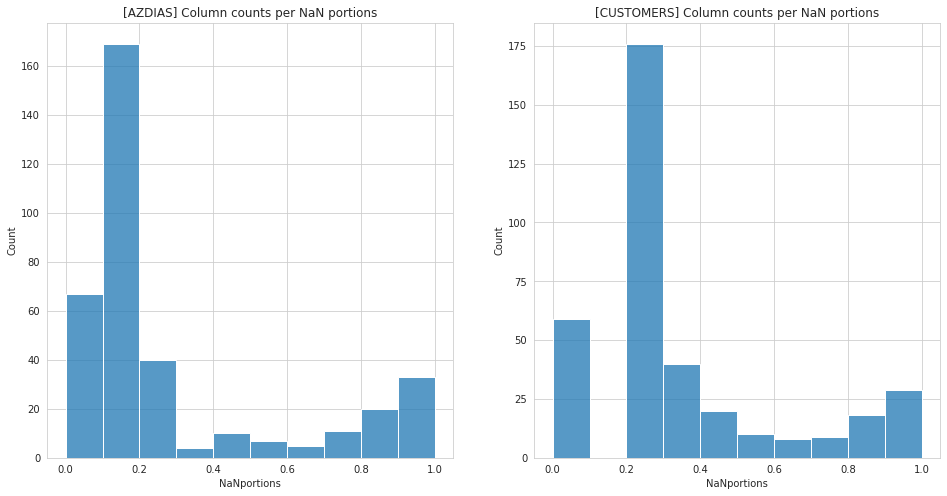

In [60]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 2, figsize=(16,8))
    sns.histplot(ax=ax[0], data=azdias_nans, x="NaNportions", bins=np.linspace(0, 1, 11)).set(title='[AZDIAS] Column counts per NaN portions')
    sns.histplot(ax=ax[1], data=cus_df_nans, x="NaNportions", bins=np.linspace(0, 1, 11)).set(title='[CUSTOMERS] Column counts per NaN portions')

We can see that both datasets have similar distributions of NaNs. The first plot for `azdias` shows that there are about 50+ attributes with NaNs above 80%. Around 280 attributes have less than 30% NaNs while the rest are between 30% - 80% NaNs. The second for `customers` shows that there are around 235 attributes with less than 30% NaNs and around 50 with more than 80% NaNs. We can confirm this with `value_counts`:

* `AZDIAS`


In [61]:
azd_col_nan_bins = azdias_nans.NaNportions.value_counts(bins=np.linspace(0, 1, 11), sort=False)

azd_col_nan_bins = azd_col_nan_bins.rename_axis("Bins").reset_index(name="Count")

azd_col_nan_bins["ColPortion"] = azd_col_nan_bins.Count / azdias.shape[1]

azd_col_nan_bins

,Bins,Count,ColPortion
0,"(-0.001, 0.1]",67,0.183060
1,"(0.1, 0.2]",169,0.461749
2,"(0.2, 0.3]",40,0.109290
3,"(0.3, 0.4]",4,0.010929
4,"(0.4, 0.5]",10,0.027322
5,"(0.5, 0.6]",7,0.019126
6,"(0.6, 0.7]",5,0.013661
7,"(0.7, 0.8]",11,0.030055
8,"(0.8, 0.9]",20,0.054645
9,"(0.9, 1.0]",33,0.090164


In [62]:
azd_col_nan_bins.loc[:2,].sum()

Count         276.000000
ColPortion      0.754098
dtype: float64

* `CUSTOMERS`

In [63]:
cus_col_nan_bins = cus_df_nans.NaNportions.value_counts(bins=np.linspace(0, 1, 11), sort=False)

cus_col_nan_bins = cus_col_nan_bins.rename_axis("Bins").reset_index(name="Count")

cus_col_nan_bins["ColPortion"] = cus_col_nan_bins.Count / custrs.shape[1]

cus_col_nan_bins

,Bins,Count,ColPortion
0,"(-0.001, 0.1]",59,0.159892
1,"(0.1, 0.2]",0,0.000000
2,"(0.2, 0.3]",176,0.476965
3,"(0.3, 0.4]",40,0.108401
4,"(0.4, 0.5]",20,0.054201
5,"(0.5, 0.6]",10,0.027100
6,"(0.6, 0.7]",8,0.021680
7,"(0.7, 0.8]",9,0.024390
8,"(0.8, 0.9]",18,0.048780
9,"(0.9, 1.0]",29,0.078591


In [64]:
cus_col_nan_bins.loc[:2,].sum()

Count         235.000000
ColPortion      0.636856
dtype: float64

####Format data for plotting

We need to convert the dataframe to [long-form](http://seaborn.pydata.org/tutorial/data_structure.html#long-form-vs-wide-form-data) to use the `hue` argument in `sns.barplot` to plot the data.

In [65]:
merge_col_nan_bins = pd.merge(azd_col_nan_bins, cus_col_nan_bins, on='Bins', suffixes=("_azd", "_cus"))

merge_col_nan_bins.head()

,Bins,Count_azd,ColPortion_azd,Count_cus,ColPortion_cus
0,"(-0.001, 0.1]",67,0.183060,59,0.159892
1,"(0.1, 0.2]",169,0.461749,0,0.000000
2,"(0.2, 0.3]",40,0.109290,176,0.476965
3,"(0.3, 0.4]",4,0.010929,40,0.108401
4,"(0.4, 0.5]",10,0.027322,20,0.054201


In [66]:
cols_nan_portns_melt = merge_col_nan_bins[
                                          ['Bins', 'ColPortion_azd', 'ColPortion_cus']
                                         ].melt(id_vars=('Bins'))
cols_nan_portns_melt.head()

,Bins,variable,value
0,"(-0.001, 0.1]",ColPortion_azd,0.183060
1,"(0.1, 0.2]",ColPortion_azd,0.461749
2,"(0.2, 0.3]",ColPortion_azd,0.109290
3,"(0.3, 0.4]",ColPortion_azd,0.010929
4,"(0.4, 0.5]",ColPortion_azd,0.027322


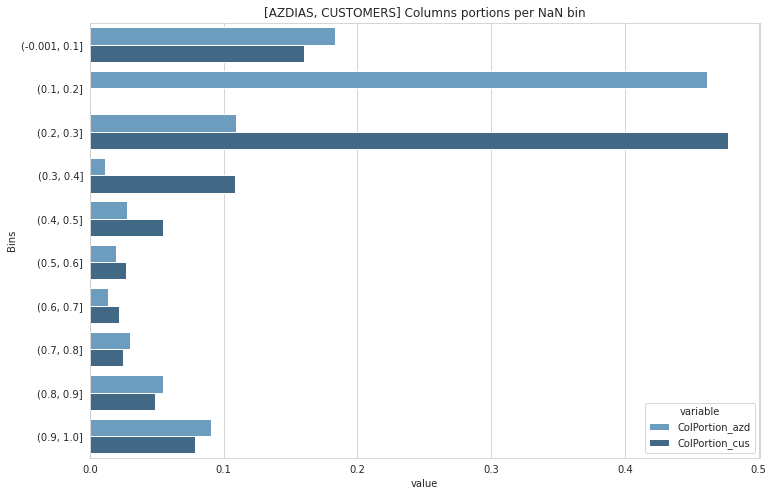

In [70]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(12,8))
    sns.barplot(data=cols_nan_portns_melt, x="value", y="Bins", hue="variable", palette="Blues_d").set(title='[AZDIAS, CUSTOMERS] Columns portions per NaN bin')

###Rows NaNs analysis

* Identify missing values per row as percentage (portions).
* Drop rows with all NaNs (zero rows will be droppped):

In [71]:
def rows_nans_info(df, cols=None):
    """Return a new dataframe with NaNs summary per row of the input df

    Creates and returns a new dataframe with three columns that correspond to
    the rows of the input dataframe, the NaN counts per row
    and portion of NaNs per row.

    Args:
        df (pd.DataFrame): The input dataframe to process.
        cols (tuple): 3 elements tuple with the names of the three columns in the
        output dataframe. If left None the three default names ('Rows',
        'NaNcounts', 'NaNportions') will be used.
    
    Returns:
        A new dataframe with three columns providing counts and portions of NaNs
        per row in the input df. Examle:

            Rows    NaNcounts	NaNportions
        0	0	    685843	    0.769554
        1	1       73499	    0.082470
        2	2	    310267	    0.348137
        3	3	    810163	    0.909048
        4	4       861722	    0.966900
    """
    cols = cols or ('Rows', 'NaNcounts', 'NaNportions')
    new_df = df.isna().sum(axis=1).rename_axis(cols[0]).reset_index(name=cols[1])
    new_df[cols[2]] = new_df[cols[1]] / df.shape[1]

    print("Average NaNs per row: ", round(new_df[cols[2]].mean(), 4))
    print("Max NaNs per row: ", round(new_df[cols[2]].max(), 4))
    print("Min NaNs per row: ", round(new_df[cols[2]].min(), 4))

    return new_df

* `AZDIAS`

In [72]:
azdias_row_nans = rows_nans_info(azdias)

azdias_row_nans.NaNportions.describe()

Average NaNs per row:  0.2798
Max NaNs per row:  0.8579
Min NaNs per row:  0.0738


count    200000.000000
mean          0.279800
std           0.197866
min           0.073770
25%           0.183060
50%           0.213115
75%           0.243169
max           0.857923
Name: NaNportions, dtype: float64

* `CUSTOMERS`

In [73]:
custrs_row_nans = rows_nans_info(custrs)

custrs_row_nans.NaNportions.describe()

Average NaNs per row:  0.3553
Max NaNs per row:  0.8537
Min NaNs per row:  0.0759


count    150000.000000
mean          0.355295
std           0.287496
min           0.075881
25%           0.165312
50%           0.195122
75%           0.745257
max           0.853659
Name: NaNportions, dtype: float64

There is on average a 28% missing values per row in `AZDIAS` and around 35% NaNs per row in `CUSTOMERS`.

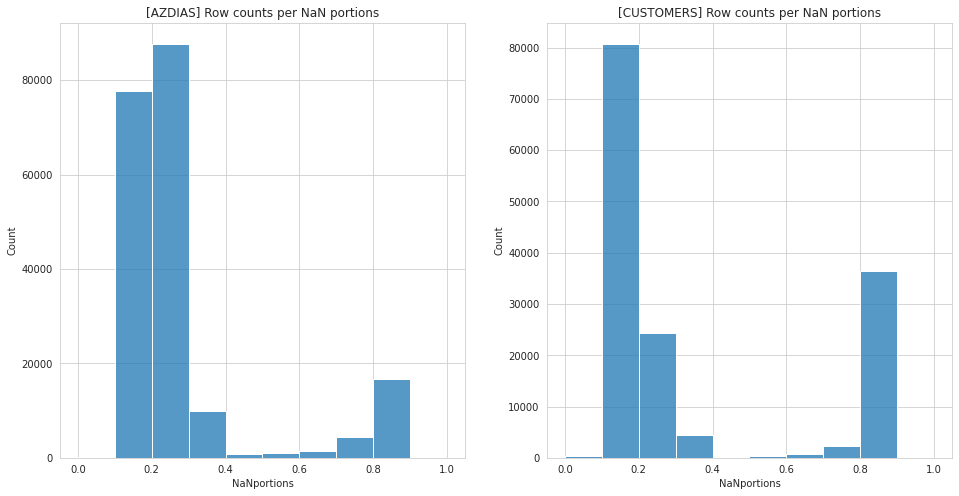

In [75]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 2, figsize=(16,8))
    sns.histplot(ax=ax[0], data=azdias_row_nans, x="NaNportions", bins=np.linspace(0, 1, 11)).set(title='[AZDIAS] Row counts per NaN portions')
    sns.histplot(ax=ax[1], data=custrs_row_nans, x="NaNportions", bins=np.linspace(0, 1, 11)).set(title='[CUSTOMERS] Row counts per NaN portions')

As seen both datasets have most rows with missing values in the range 10% - 30% per row.

* `AZDIAS`

In [76]:
azd_row_nan_bins = azdias_row_nans.NaNportions.value_counts(bins=np.linspace(0, 1, 11), sort=False)

azd_row_nan_bins = azd_row_nan_bins.rename_axis("Bins").reset_index(name="Count")

azd_row_nan_bins["RowPortion"] = azd_row_nan_bins.Count / azdias.shape[0]

azd_row_nan_bins

,Bins,Count,RowPortion
0,"(-0.001, 0.1]",170,0.000850
1,"(0.1, 0.2]",77776,0.388880
2,"(0.2, 0.3]",87739,0.438695
3,"(0.3, 0.4]",10002,0.050010
4,"(0.4, 0.5]",774,0.003870
5,"(0.5, 0.6]",1070,0.005350
6,"(0.6, 0.7]",1341,0.006705
7,"(0.7, 0.8]",4420,0.022100
8,"(0.8, 0.9]",16708,0.083540
9,"(0.9, 1.0]",0,0.000000


In [77]:
# 20% NaN counts and dataset poriton - AZDIAS
azd_row_nan_bins.loc[:2,].sum()

Count         165685.000000
RowPortion         0.828425
dtype: float64

* `CUSTOMERS`

In [78]:
cus_row_nan_bins = custrs_row_nans.NaNportions.value_counts(bins=np.linspace(0, 1, 11), sort=False)

cus_row_nan_bins = cus_row_nan_bins.rename_axis("Bins").reset_index(name="Count")

cus_row_nan_bins["RowPortion"] = cus_row_nan_bins.Count / custrs.shape[0]

cus_row_nan_bins

,Bins,Count,RowPortion
0,"(-0.001, 0.1]",261,0.001740
1,"(0.1, 0.2]",80790,0.538600
2,"(0.2, 0.3]",24415,0.162767
3,"(0.3, 0.4]",4394,0.029293
4,"(0.4, 0.5]",241,0.001607
5,"(0.5, 0.6]",255,0.001700
6,"(0.6, 0.7]",806,0.005373
7,"(0.7, 0.8]",2389,0.015927
8,"(0.8, 0.9]",36449,0.242993
9,"(0.9, 1.0]",0,0.000000


In [79]:
# 20% NaN counts and dataset poriton - CUSTOMERS
cus_row_nan_bins.loc[:2,].sum()

Count         105466.000000
RowPortion         0.703107
dtype: float64

####Format data in long-form for plotting with `sns.barplot`. 

In [80]:
merge_row_nan_bins = pd.merge(azd_row_nan_bins, cus_row_nan_bins,
                              on='Bins', suffixes=("_azd", "_cus"))

rows_nan_portns_melt = merge_row_nan_bins[
                                          ['Bins', 'RowPortion_azd', 'RowPortion_cus']
                                         ].melt(id_vars=('Bins'))

rows_nan_portns_melt.head()

,Bins,variable,value
0,"(-0.001, 0.1]",RowPortion_azd,0.000850
1,"(0.1, 0.2]",RowPortion_azd,0.388880
2,"(0.2, 0.3]",RowPortion_azd,0.438695
3,"(0.3, 0.4]",RowPortion_azd,0.050010
4,"(0.4, 0.5]",RowPortion_azd,0.003870


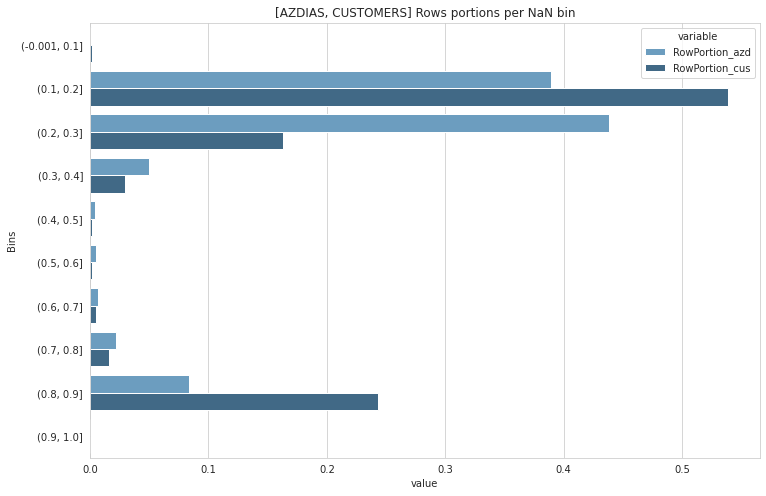

In [81]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(12,8))
    sns.barplot(data=rows_nan_portns_melt, x="value", y="Bins", hue="variable", palette="Blues_d").set(title='[AZDIAS, CUSTOMERS] Rows portions per NaN bin')


In both datasets most rows have NaNs in the range 10% - 30%.


####Column type and exploration for the attributes with values range `'…'`

Finally we have the special cases where values' pool was `'…'`, described with the `attrs_val_dict_any` dictionary mapping. These include a wide range of numerical values:

* `AZDIAS`

In [82]:
# Check `attrs_val_dict_any` special cases types:
azdias.loc[:, attrs_val_dict_any.keys()].dtypes

ANZ_HAUSHALTE_AKTIV    float64
ANZ_HH_TITEL           float64
ANZ_PERSONEN           float64
ANZ_TITEL              float64
GEBURTSJAHR            float64
KBA13_ANZAHL_PKW       float64
MIN_GEBAEUDEJAHR       float64
dtype: object

In [83]:
azdias.loc[:, attrs_val_dict_any.keys()].describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR
count,177706.000000,5458.000000,175774.000000,691.000000,111962.000000,176269.000000,179151.000000
mean,8.416373,1.368450,1.800693,1.073806,1967.145264,617.631852,1993.299262
std,16.032139,1.424545,1.123983,0.282935,17.858062,338.716225,3.375281
min,1.000000,1.000000,1.000000,1.000000,1900.000000,1.000000,1985.000000
25%,2.000000,1.000000,1.000000,1.000000,1955.000000,381.000000,1992.000000
50%,4.000000,1.000000,1.000000,1.000000,1968.000000,547.000000,1992.000000
75%,10.000000,1.000000,2.000000,1.000000,1981.000000,777.000000,1993.000000
max,523.000000,23.000000,40.000000,3.000000,2017.000000,2300.000000,2016.000000


We may observe that values for the above attributes look acceptable.

In [84]:
# Count unique values per attribute (column)
azdias.loc[:, attrs_val_dict_any.keys()].nunique()

ANZ_HAUSHALTE_AKTIV     250
ANZ_HH_TITEL             18
ANZ_PERSONEN             18
ANZ_TITEL                 3
GEBURTSJAHR             115
KBA13_ANZAHL_PKW       1255
MIN_GEBAEUDEJAHR         32
dtype: int64

In [85]:
# Discrete unique values per column
azdias.loc[:, attrs_val_dict_any.keys()].apply(lambda col: col.unique())

ANZ_HAUSHALTE_AKTIV    [1.0, 40.0, 4.0, 7.0, 6.0, nan, 2.0, 5.0, 9.0,...
ANZ_HH_TITEL           [nan, 1.0, 2.0, 8.0, 3.0, 4.0, 6.0, 13.0, 7.0,...
ANZ_PERSONEN           [4.0, nan, 1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 10.0,...
ANZ_TITEL                                           [nan, 1.0, 2.0, 3.0]
GEBURTSJAHR            [1994.0, 1921.0, nan, 2011.0, 1969.0, 1981.0, ...
KBA13_ANZAHL_PKW       [546.0, 311.0, 945.0, 482.0, 125.0, nan, 371.0...
MIN_GEBAEUDEJAHR       [1992.0, nan, 1997.0, 2009.0, 1996.0, 1988.0, ...
dtype: object

* `CUSTOMERS`

In [86]:
# Check `attrs_val_dict_any` special cases types:
custrs.loc[:, attrs_val_dict_any.keys()].dtypes

ANZ_HAUSHALTE_AKTIV    float64
ANZ_HH_TITEL           float64
ANZ_PERSONEN           float64
ANZ_TITEL              float64
GEBURTSJAHR            float64
KBA13_ANZAHL_PKW       float64
MIN_GEBAEUDEJAHR       float64
dtype: object

In [88]:
custrs.loc[:, attrs_val_dict_any.keys()].describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR
count,109061.000000,4806.00000,108008.000000,2153.000000,77250.000000,109969.000000,110987.000000
mean,5.071694,1.55722,2.385749,1.080353,1949.782861,667.147232,1993.047618
std,14.578718,2.15419,1.324750,0.283613,14.939949,340.677636,3.056307
min,1.000000,1.00000,1.000000,1.000000,1900.000000,5.000000,1985.000000
25%,1.000000,1.00000,1.000000,1.000000,1939.000000,430.000000,1992.000000
50%,1.000000,1.00000,2.000000,1.000000,1948.000000,593.000000,1992.000000
75%,4.000000,1.00000,3.000000,1.000000,1960.000000,828.000000,1992.000000
max,523.000000,23.00000,21.000000,3.000000,2017.000000,2300.000000,2016.000000


In [87]:
# Count unique values per attribute (column)
custrs.loc[:, attrs_val_dict_any.keys()].nunique()

ANZ_HAUSHALTE_AKTIV     208
ANZ_HH_TITEL             19
ANZ_PERSONEN             17
ANZ_TITEL                 3
GEBURTSJAHR             110
KBA13_ANZAHL_PKW       1248
MIN_GEBAEUDEJAHR         32
dtype: int64

In [89]:
# Discrete unique values per column
custrs.loc[:, attrs_val_dict_any.keys()].apply(lambda col: col.unique())

ANZ_HAUSHALTE_AKTIV    [nan, 8.0, 7.0, 1.0, 6.0, 74.0, 9.0, 2.0, 12.0...
ANZ_HH_TITEL           [nan, 2.0, 4.0, 1.0, 6.0, 5.0, 20.0, 9.0, 3.0,...
ANZ_PERSONEN           [nan, 2.0, 4.0, 1.0, 3.0, 5.0, 6.0, 7.0, 8.0, ...
ANZ_TITEL                                           [nan, 1.0, 2.0, 3.0]
GEBURTSJAHR            [nan, 1960.0, 1975.0, 1914.0, 1959.0, 1943.0, ...
KBA13_ANZAHL_PKW       [nan, 240.0, 755.0, 513.0, 1167.0, 714.0, 177....
MIN_GEBAEUDEJAHR       [nan, 1992.0, 1994.0, 1995.0, 1997.0, 2001.0, ...
dtype: object

## Identifing (if any) columns to drop

At this point we will proceed concatenating the two samples in a single dataframe, creating a new feature `TARGET` that will be `1` for customers and `-1` for unknown.

This will combine attribute characteristics from both datasets and help us make decisions best on both samples.

First let us check if there are any common user IDs in LNR colums:

In [90]:
np.intersect1d(azdias.LNR.values, custrs.LNR.values)

array([], dtype=int64)

Concatenate the dataframes:

In [91]:
# Create a new dataframe from `azdias` and `customers` dataframes creating a `target` attribute:
df_train = pd.concat([azdias.assign(TARGET=-1),
                      custrs.drop(columns=["CUSTOMER_GROUP", "ONLINE_PURCHASE", "PRODUCT_GROUP"])
                      .assign(TARGET=1)])

# Shuffle dataframe
df_train = df_train.sample(frac=1).reset_index(drop=True)

# Keep "LNR" IDs
clientIDs = df_train["LNR"]

# Remove "LNR" and "EINGEFUEGT_AM" columns which are client IDs and entry datetimes
df_train.drop(columns=["LNR", "EINGEFUEGT_AM"], inplace=True)

df_train.shape

(350000, 365)

In [92]:
df_train.dtypes.value_counts()

float64     357
int64         5
category      1
category      1
category      1
dtype: int64

In [93]:
# Convert float columns to int.
df_train_int_cols = df_train.select_dtypes(include=['float64']).fillna(-1.0).astype(int)
df_train.loc[:, df_train_int_cols.columns] = df_train_int_cols

In [94]:
df_train.dtypes.value_counts()

int64       362
category      1
category      1
category      1
dtype: int64

### One-hot encoding

One-hot encode categorical attributes `CAMEO_DEU_2015, D19_LETZTER_KAUF_BRANCHE, OST_WEST_KZ`.

In [95]:
df_train.select_dtypes(include='category').head()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
0,7A,D19_ENERGIE,O
1,7A,D19_UNBEKANNT,O
2,4A,D19_HAUS_DEKO,W
3,2D,D19_SONSTIGE,W
4,1A,NaN,O


In [96]:
df_train = pd.get_dummies(df_train)
# azd_cp = pd.get_dummies(azdias)
# cus_cp = pd.get_dummies(custrs)

df_train.shape

(350000, 443)

In [97]:
# Match the columns in the dataframes
# azd_cp, cus_cp = azd_cp.align(cus_cp, join = 'inner', axis = 1)
# print('Azdias copy shape: ', azd_cp.shape)
# print('Customers copy shape: ', cus_cp.shape)

In [98]:
# Remove "LNR" and "EINGEFUEGT_AM" columns which are client IDs and entry datetimes

# azd_cp.drop(columns=["LNR", "EINGEFUEGT_AM"], errors='ignore', inplace=True)
# cus_cp.drop(columns=["LNR", "EINGEFUEGT_AM"], errors='ignore', inplace=True)

# azd_cp.shape, cus_cp.shape

irrelevant features, highly correlated features, and missing values can prevent the model from learning and decrease generalization performance on the testing data

## Feature selection to keep only the most useful attributes

* Start with **collinear** attributes
(Ref: https://chrisalbon.com/code/machine_learning/feature_selection/drop_highly_correlated_features/)

Calculate correlation on a stratified sample of the data, since `azdias` dataframe is large enough that notebook runs out of memory while calculating the correlation matrix.

In [99]:
def get_stratified_samples(df, fracs=np.array([0.2, 0.8])):
    """Split an input df into two stratified sub-sets of sizes indicated
    by the fracs array.
    """
    # shuffle input df
    df_ = df.sample(frac=1) 
    # split into 2 parts, return df_smpl_a, df_smpl_b
    return np.array_split(df_, (fracs[:-1].cumsum() * len(df_)).astype(int))

# azd_cp_smpl_a, azd_cp_smpl_b = get_stratified_samples(azd_cp)

# azd_cp_smpl_a.shape, azd_cp_smpl_b.shape

In [100]:
def drop_collinear_cols(df, threshold=0.95):
    """Ιdentifies the highly correlated variables based on the absolute
    magnitude of the Pearson correlation coefficient being greater than threshold (0.9)

    Args:
        df (pd.Dataframe): Input dataframe to work on
        threshold (float): threshold value above which the columns will selected
    
    Returns:
        np.array of selected collumns based on the threshold value.
    """
    # Calculate absolute value correlation matrix from the input df.
    # corr_mat = df.corr().abs()
    corr_mat = np.abs(np.corrcoef(df, rowvar=False))
    # Convert to dataframe
    corr_mat = pd.DataFrame(corr_mat, index=df.columns, columns=df.columns)
    # Select upper triangle of correlation matrix
    upr = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
    # Find index of attribute columns with correlation greater than `threshold`
    return np.array([c for c in upr.columns if any(upr[c] > threshold)])


In [101]:
# Find attribute columns with correlation greater than 0.95
to_drop = drop_collinear_cols(df_train)

to_drop, len(to_drop)

(array(['ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_INTL_2015', 'KBA05_KRSHERST2',
        'KBA05_KRSHERST3', 'KBA05_SEG2', 'KBA13_HALTER_30',
        'KBA13_HALTER_40', 'KBA13_HALTER_55', 'KBA13_HALTER_66',
        'KBA13_HERST_SONST', 'KBA13_KMH_250', 'KBA13_MERCEDES',
        'KBA13_SEG_VAN', 'KBA13_VW', 'LP_FAMILIE_GROB',
        'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB',
        'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ'], dtype='<U26'), 21)

In [102]:
# Find attribute columns with correlation greater than 0.95
# to_drop_azd = drop_collinear_cols(azd_cp_smpl_a)

# to_drop_azd, len(to_drop_azd)

We will do the same in the `CUSTOMERS` dataset to compare the attributes identified for dropping.

In [ ]:
# CUSTOMERS
# cus_cp_smpl_a, cus_cp_smpl_b = get_stratified_samples(cus_cp)

# cus_cp_smpl_a.shape, cus_cp_smpl_b.shape

In [ ]:
# Find attribute columns with correlation greater than 0.95
# to_drop_cus = drop_collinear_cols(cus_cp_smpl_a)

# to_drop_cus, len(to_drop_cus)

Let's drop only the common ones identified in both datatsets' samples.

In [ ]:
# to_drop = set(to_drop_azd).intersection(to_drop_cus)
# to_drop = np.intersect1d(to_drop_azd, to_drop_cus)

# to_drop, len(to_drop)

In [ ]:
# Clean up memory
# del azd_cp, cus_cp, azd_cp_smpl_a, azd_cp_smpl_b, cus_cp_smpl_a, cus_cp_smpl_b
# gc.collect()

In [103]:
df_train.drop(columns=to_drop, inplace=True)

df_train.shape

(350000, 422)

###Search more columns with high NaN ratio, check their significance.

References:
* https://www.kaggle.com/questions-and-answers/131935
* https://stats.stackexchange.com/questions/221332/variance-of-a-distribution-of-multi-level-categorical-data

Check attributes with NaN ratio more than **0.8**.

In [104]:
df_train_nans = cols_nans_info(df_train.replace(-1, np.NaN))

df_train_nans

Average NaNs per column:  0.2611
Max NaNs per column:  0.999
Min NaNs per column:  0.0


,Columns,NaNcounts,NaNportions
0,AGER_TYP,229566,0.655903
1,AKT_DAT_KL,52875,0.151071
2,ALTER_HH,123536,0.352960
3,ALTER_KIND1,322454,0.921297
4,ALTER_KIND2,339395,0.969700
...,...,...,...
417,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,0,0.000000
418,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,0,0.000000
419,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,0,0.000000
420,OST_WEST_KZ_O,0,0.000000


In [105]:
# Select the columns with NaNs more than 80% to check for variabiltiy
df_train_nans_gt80 = df_train_nans.loc[(df_train_nans["NaNportions"] > .8), "Columns"].values

df_train_nans_gt80, df_train_nans_gt80.size

(array(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
        'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_TITEL', 'D19_BANKEN_ANZ_12',
        'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS',
        'D19_BANKEN_LOKAL', 'D19_BANKEN_ONLINE_QUOTE_12',
        'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BILDUNG',
        'D19_BIO_OEKO', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL',
        'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_HANDWERK',
        'D19_KINDERARTIKEL', 'D19_LEBENSMITTEL', 'D19_NAHRUNGSERGAENZUNG',
        'D19_RATGEBER', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
        'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_MOBILE',
        'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 'D19_TIERARTIKEL',
        'D19_VERSAND_REST', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
        'D19_VERSI_ONLINE_QUOTE_12', 'D19_WEIN_FEINKOST', 'HH_DELTA_FLAG',
        'KBA05_ANTG4', 'KBA05_SEG6', 'KONSUMZELLE', 'SOHO_KZ', 'TITEL_KZ',
        'UNGLEICHENN_FLAG'], dtype=objec

In [ ]:
# Select the columns with NaNs more than 80% to check for variabiltiy
# azdias_nans_gt80 = azdias_nans.loc[(azdias_nans["NaNportions"] > .8), "Columns"].values

# azdias_nans_gt80, azdias_nans_gt80.size

In [ ]:
# cus_nans_gt80 = cus_df_nans.loc[(cus_df_nans["NaNportions"] > .8), "Columns"].values

# cus_nans_gt80, cus_nans_gt80.size

In [ ]:
# Filter `azdias` dataset to select the above columns only.
# azdias.filter(azdias_nans_gt80).dtypes.value_counts()

In [106]:
df_train.filter(df_train_nans_gt80).dtypes.value_counts()

int64    47
dtype: int64

We will calculate the **entropy** on the above (ordinal variables) as a measure of the amount of information in a categorical variable. We will attempt to identify columns with little to no information at all.

To do this we will create a function to calculate the entropy in a given column.

In [107]:
def get_entropy(labels):
    """Calculate the entropy of a data series.

    Calculate the entropy based on Shannon's entropy (log2).
    Scipy entropy() will normalize values' frequencies if
    they don’t sum to 1.

    Args:
        labels (pd.Series): pandas Series to calculate entropy
    
    Returns:
        ent: The calculated entropy of the input labels
    """
    # get values' frequencies
    vals_freq = labels.value_counts(sort=False)
    ent = entropy(vals_freq, base=2)
    
    return ent

A mapping of attribute names (columns) and entropy can be created. This will allow us to decide if we should drop some more columns with high percentage of NaNs that also offer little to no information.

In [108]:
def drop_nan_cols(df, df_nans_cols, nan_thres=.8, use_entropy=True, ent_thres=1.0):
    """Get df columns with higher NaN percent than  nan_thres (> 80%) and return
    the ones with entropy < ent_thres. If use_entropy=False return all columns
    with NaN portion higher than nan_thres.

    Returns:
        drop_cols (np.array): Highr percentage NaN columns list (with low entropy)
        ent (dict): Mapping of attributes names with entropy values for selected
        columns range (or None if entropy not used). 
    """
    # Select the columns with NaNs more than nan_thres to check for variabiltiy
    df_nans_cols_gt80 = df_nans_cols.loc[(df_nans_cols["NaNportions"] > nan_thres),
                                         "Columns"].values
    # Filter the dataset to select the above columns only.
    df_var_nan80 = df.filter(df_nans_cols_gt80)
    drop_cols = df_var_nan80.values
    ent = None
    if use_entropy:
        # Calculate entropy & create maping
        ent = {i: round(get_entropy(df_var_nan80[i]), 4) for i in df_var_nan80}
        # From the dictionary we will select the columns with entropy less than ent_thres
        df_ent_drop = [i for i in ent if ent[i] < ent_thres]
        drop_cols = np.array(df_ent_drop)

    return drop_cols, ent


In [109]:
# Get df_train columns with higher NaN percent (> 80%) and return the ones with entropy < 1.0
df_train_ent_drop, df_train_var_nan80_ent = drop_nan_cols(df_train, df_train_nans)

df_train_ent_drop, len(df_train_ent_drop)

(array(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
        'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_TITEL', 'D19_BANKEN_ANZ_12',
        'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS',
        'D19_BANKEN_LOKAL', 'D19_BANKEN_ONLINE_QUOTE_12',
        'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BILDUNG',
        'D19_BIO_OEKO', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL',
        'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_HANDWERK',
        'D19_LEBENSMITTEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER',
        'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_TELKO_ANZ_12',
        'D19_TELKO_ANZ_24', 'D19_TELKO_MOBILE',
        'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 'D19_TIERARTIKEL',
        'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
        'D19_VERSI_ONLINE_QUOTE_12', 'D19_WEIN_FEINKOST', 'HH_DELTA_FLAG',
        'KBA05_ANTG4', 'KBA05_SEG6', 'KONSUMZELLE', 'SOHO_KZ', 'TITEL_KZ',
        'UNGLEICHENN_FLAG'], dtype='<U26'), 45)

In [ ]:
# Get azdias columns with higher NaN percent (> 80%) and return the ones with entropy < 1.0
# azd_ent_drop, azdias_var_nan80_ent = drop_nan_cols(azdias, azdias_nans)

# azd_ent_drop, len(azd_ent_drop)

Check if there are any attributes in common with the ones selected with the correlation matrix method (`to_drop`)

In [ ]:
# np.intersect1d(np.array(to_drop), azdias_nans_gt80)

In [ ]:
# np.intersect1d(to_drop, azd_ent_drop)

In [110]:
# Create plot data, in a new df get 'Attributes', 'Entropy' and "NaNportions"
plt_data = pd.DataFrame(df_train_var_nan80_ent.items(), columns=['Attributes', 'Entropy'])

# Get NaN portions for the attributes with NaNs more than 80%
plt_data["NaNportions"] = df_train_nans.loc[df_train_nans["Columns"]
                                            .isin(df_train_nans_gt80),"NaNportions"].values

# Sort by `Entropy` values
plt_data.sort_values("Entropy", ascending=False, inplace=True)

plt_data.head()

,Attributes,Entropy,NaNportions
23,D19_KINDERARTIKEL,1.0211,0.823531
35,D19_VERSAND_REST,1.0083,0.831686
18,D19_DROGERIEARTIKEL,0.9862,0.847686
9,D19_BANKEN_DIREKT,0.9778,0.840603
31,D19_TELKO_MOBILE,0.9472,0.822240


In [ ]:
# Create plot data, in a new df get 'Attributes', 'Entropy' and "NaNportions"
# plt_data = pd.DataFrame(azdias_var_nan80_ent.items(), columns=['Attributes', 'Entropy'])

# Get NaN portions for the attributes with NaNs more than 80%
# plt_data["NaNportions"] = azdias_nans.loc[azdias_nans["Columns"].isin(azdias_nans_gt80), "NaNportions"].values

# Sort by `Entropy` values
# plt_data.sort_values("Entropy", ascending=False, inplace=True)

# plt_data.head()

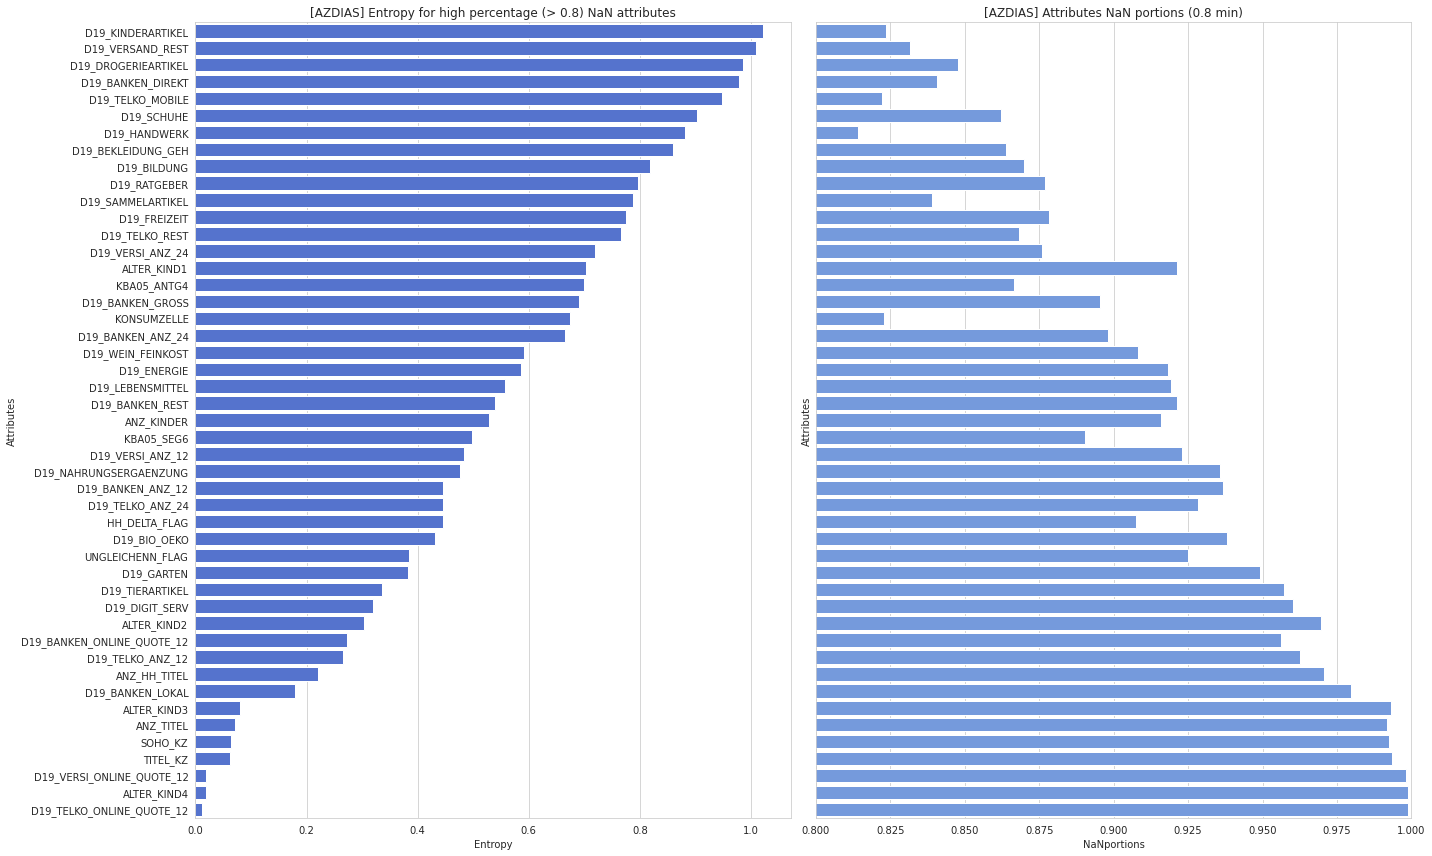

In [112]:
# Let's visualize the results
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 2, figsize=(20,12), sharey=True)
    sns.barplot(ax=ax[0], data=plt_data, x='Entropy', y='Attributes', color='royalblue').set(
        title='[AZDIAS] Entropy for high percentage (> 0.8) NaN attributes')
    sns.barplot(ax=ax[1], data=plt_data, x='NaNportions', y='Attributes', color='cornflowerblue').set(
        title='[AZDIAS] Attributes NaN portions (0.8 min)', xlim=(0.8,1.0))
    fig.tight_layout()


Plots show that some of the attributes found with the lowest entropy also have a high number of NaNs. Checking entropy as a measure of information per column will allow us to drop those columns with high percentage of NaNs, with more confidence than just choosing to drop columns above a high NaN percentage threshold.

###Drop previously identified attributes

* Drop collinear attributes in `to_drop` array.
* Drop attributes in `azd_ent_drop` with NaNs more than 80%, also identified with the lowest entropy among the rest with such high NaN percentage.
* Drop `CUSTOMERS` specific attributes (`'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'`).
* Drop the datetime `EINGEFUEGT_AM`.

In [113]:
df_train.drop(columns=df_train_ent_drop, inplace=True)

df_train.shape

(350000, 377)

At this point all the previous steps can be aggregated in a single function to help us manipulate datasets in the following steps. We will include `zero_imp_attrs` as an optional parameter that will be used in following analysis (in parts 2 and 3).

In [114]:
def wrangle_df(df, val_pools, common_attrs, replace_nan, zero_imp_attrs=None):
    """Clean and fix an input demographics dataframe for this project.

    This function is for cleaning and fixing datasets for this project. It
    returns a clean dataframe with several columns dropped based on identified
    NaNs, entropy and  collinearity. Additionally, value per column are checked
    and replaced with NaNs if they fall outside an accepted values pool.

    Args:
        df (pd.Dataframe): Input demographics datafrme (The notebook crashes when
            the entire `azdias` is loaded).
        val_pools (dict): A dictionary with keys the attributes names and values
            lists with the allowed values for each attribute. e.g.:
            {'AGER_TYP': [nan, -1, 0, 1, 2, 3], ...}
        common_attrs (np.array): Common attributes (attrs_common) between
            demographic dataset and excel files. e.g.:
            (array(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', ...)]
        replace_nan (dict): Mapping of attributes and values to replace with NaNs
            within each attribute. e.g. {'AGER_TYP': 9} will replace 9 in 'AGER_TYP'
            with NaN.
        zero_imp_attrs (array like or None): `zero_val_attrs` computed zero
            importance attributes. If provided these will be dropped from the
            input df.
    
    Returns:
        df (pd.Dataframe): The cleaned and fixed df.
    """
    # Keep "LNR" IDs
    clientIDs = df["LNR"]

    # Drop `customer` specific attributes.
    other_to_drop = np.array(["CUSTOMER_GROUP", "ONLINE_PURCHASE", "PRODUCT_GROUP"])

    # Remove "LNR" and "EINGEFUEGT_AM" columns which are client IDs and entry datetimes
    df.drop(columns=np.union1d(["LNR", "EINGEFUEGT_AM"], other_to_drop),
            errors='ignore', inplace=True)

    # find object columns
    cat_cols = df.select_dtypes(include=object).columns.tolist()
    # Convert to category columns
    df[cat_cols] = df[cat_cols].astype('category')

    # Replace unkown and specific values with NaNs
    # for every key (attribute) in the dictionary created earlier
    for k in val_pools:
        # if the attribute is among the common ones
        if k in common_attrs:
            # select all those rows in the column that fall outside the attritbute's specified values pool and replace them with NaN.
            df.loc[~df[k].isin(val_pools[k]), k] = np.NaN
    # Use a dictionary mapping of attributes to replace value 9 (unknown) for NaN for specifc attributes.
    df.replace(replace_nan, np.NaN, inplace=True)

    # NaNs
    # Total
    print("Total df NaNs portion: ", round(df.isna().sum().sum() / df.size, 4))
    # Columns
    print("Column NaNs:")
    df_cols_nans = cols_nans_info(df)
    # Rows
    print("Row NaNs:")
    df_rows_nans = rows_nans_info(df)

    # Convert float columns to int.
    df_int_cols = df.select_dtypes(include=['float64']).fillna(-1.0).astype(int)
    df.loc[:, df_int_cols.columns] = df_int_cols

    # One-hot encoding, for ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ']
    df = pd.get_dummies(df)

    # Create two stratified samples of the input dataframe.
    # df_a, df_b = get_stratified_samples(df)

    # Find attribute columns with correlation greater than 0.95 and drop them
    corr_cols_to_drop = drop_collinear_cols(df)
    df.drop(columns=corr_cols_to_drop, inplace=True)

    # Select the columns with NaNs more than 80% and with entropy less than 1.0.
    df_ent_drop, ent = drop_nan_cols(df, df_cols_nans)
    
    # Drop above selected NaN attributes and supplied zero importance attributes.
    zero_imp_drop = zero_imp_attrs or []
    df.drop(columns=np.union1d(df_ent_drop, zero_imp_drop),
            errors='ignore', inplace=True)

    return df.assign(LNR=clientIDs.values)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

> The goal of unsupervised learning is to find the underlying structure of dataset, group that data according to similarities, and represent that dataset in a compressed format.

The unsupervised learning algorithm can be further categorized into two types of problems:

* **Clustering**: Clustering is a method of grouping the objects into clusters such that objects with most similarities remains into a group and has less or no similarities with the objects of another group. Cluster analysis finds the commonalities between the data objects and categorizes them as per the presence and absence of those commonalities.

* **Association**: An association rule is an unsupervised learning method which is used for finding the relationships between variables in the large database. It determines the set of items that occurs together in the dataset. Association rule makes marketing strategy more effective. Such as people who buy X item (suppose a bread) are also tend to purchase Y (Butter/Jam) item. A typical example of Association rule is Market Basket Analysis.

Ref: https://www.javatpoint.com/unsupervised-machine-learning

Popular unsupervised learning algorithms:

* K-means clustering
* KNN (k-nearest neighbors)
* Hierarchal clustering
* Anomaly detection
* Neural Networks
* Principle Component Analysis
* Independent Component Analysis
* Apriori algorithm
* Singular value decomposition

### Clustering with Mini Batch K-Means

We will choose the KMeans algorithm for data clustering, because it is a general-purpose clustering algorithm with even cluster sizes and has good scalability for very large samples. We will specifically use the [MiniBatch code](https://scikit-learn.org/stable/modules/clustering.html#mini-batch-kmeans), a variant of the KMeans algorithm which uses mini-batches to reduce the computation time.

The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum-of-squares criterion. However, inertia is not a normalized metric, becoming a drawback for the use of KMeans. To overcome this it is usual practice to run a dimensionality reduction algorithm such as Principal component analysis (PCA) prior to k-means clustering.

In [118]:
# Create train and target sets.
train = df_train.drop(columns=["TARGET"])
target = df_train["TARGET"]

# Create a simple pipeline initially replace -1 (missing values) with a large negative,
# before applying PCA on the data.
pca_pipeline = make_pipeline(SimpleImputer(missing_values=-1,
                                           strategy='constant',
                                           fill_value=-9999),
                             PCA(n_components=.9))

# Fit the model with train and apply the dimensionality reduction on train data
train = pca_pipeline.fit_transform(train)
# Get the percentage of variance explained by each of the selected components
pca_expl_var = pca_pipeline.named_steps.pca.explained_variance_ratio_

pca_expl_var, pca_expl_var.size

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=-9999,
                               missing_values=-1, strategy='constant',
                               verbose=0)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.9,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)

So, these components account for 0.9 explained variance ratio (the amount of variance that needs to be explained is greater than the percentage specified by n_components):

In [122]:
pca_expl_var.sum()

0.90081898485945

In [123]:
# Singular values corresponding to each of the selected components
pca_pipeline.named_steps.pca.singular_values_

array([31188876.53215628,  8154963.86198775,  7955259.1411843 ,
        4908444.55992346,  4509538.5767873 ,  4064005.16922919,
        3611209.44450028,  3383389.75985485,  2999025.352915  ,
        2938134.27013436,  2848614.50106357,  2640328.19156654,
        2495293.55461396,  2489017.56313834,  2467161.84850968,
        2448520.56423288,  2429304.79086858,  2365487.6000086 ,
        2333423.20297853,  2305875.09512135,  2294697.75891205,
        2232432.10191991,  2217051.24539753,  2198333.65953005,
        2182175.74295729,  2163934.4577492 ,  2137805.14451717,
        2107725.79455275,  2101834.26498169,  2084542.22058734,
        2069977.2762956 ,  2051725.65052598,  2041018.93863813,
        2027413.14529376,  2016357.64345456,  1996198.95525285])

In [120]:
# Create train and target sets.
train = df_train.drop(columns=["TARGET"]).replace()
target = df_train["TARGET"]

train.shape

(350000, 376)

### Clustering with feature contribution from LightGBM

Ref: https://towardsdatascience.com/applying-a-clustering-algorithm-to-feature-contribution-3c649ab0ca17

In [121]:
#we create a basic lightGBM model we'll be using for our analysis:
X_train_feat = lgb.Dataset(train, target)
parameters = {
    "n_estimators": 3,
    "max_depth":3,
    "random_state": 43
}

#we train our model
basic_model = lgb.train(parameters, train_set=X_train_feat)

#We create a contributions table
contributions = basic_model.predict(train, pred_contrib=True)

contributions

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


array([[ 0.        ,  0.00282226,  0.        , ...,  0.        ,
         0.        , -0.14285714],
       [ 0.        ,  0.00282226,  0.        , ...,  0.        ,
         0.        , -0.14285714],
       [ 0.        , -0.01014295,  0.        , ...,  0.        ,
         0.        , -0.14285714],
       ...,
       [ 0.        ,  0.0075933 ,  0.        , ...,  0.        ,
         0.        , -0.14285714],
       [ 0.        ,  0.00282226,  0.        , ...,  0.        ,
         0.        , -0.14285714],
       [ 0.        ,  0.00282226,  0.        , ...,  0.        ,
         0.        , -0.14285714]])

In [122]:
df_contributions = pd.DataFrame(contributions, columns=train.columns.tolist()+["expected_value"]).drop(columns='expected_value')

df_contributions.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BEKLEIDUNG_REST,D19_BUCH_CD,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LOTTO,D19_REISEN,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_DIREKT,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_GROSS,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_LOKAL,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_REST,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_GEH,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_REST,D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG,D19_LETZTER_KAUF_BRANCHE_D19_BIO_OEKO,D19_LETZTER_KAUF_BRANCHE_D19_BUCH_CD,D19_LETZTER_KAUF_BRANCHE_D19_DIGIT_SERV,D19_LETZTER_KAUF_BRANCHE_D19_DROGERIEARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_ENERGIE,D19_LETZTER_KAUF_BRANCHE_D19_FREIZEIT,D19_LETZTER_KAUF_BRANCHE_D19_GARTEN,D19_LETZTER_KAUF_BRANCHE_D19_HANDWERK,D19_LETZTER_KAUF_BRANCHE_D19_HAUS_DEKO,D19_LETZTER_KAUF_BRANCHE_D19_KINDERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_KOSMETIK,D19_LETZTER_KAUF_BRANCHE_D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE_D19_LOTTO,D19_LETZTER_KAUF_BRANCHE_D19_NAHRUNGSERGAENZUNG,D19_LETZTER_KAUF_BRANCHE_D19_RATGEBER,D19_LETZTER_KAUF_BRANCHE_D19_REISEN,D19_LETZTER_KAUF_BRANCHE_D19_SAMMELARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_SCHUHE,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_O,OST_WEST_KZ_W
0,0.0,0.002822,0.0,0.000117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.007696,0.0,0.0,0.0,0.000625,-0.003660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.002349,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.002822,0.0,0.000607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002005,0.0,0.0,0.0,0.000625,0.000555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.279647,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-0.010143,0.0,0.000117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000794,0.0,0.0,0.0,-0.007160,-0.006488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.120570,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.002822,0.0,0.000607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000794,0.0,0.0,0.0,-0.004039,-0.003660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.286885,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.007593,0.0,0.000117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002005,0.0,0.0,0.0,0.001108,0.000983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.107202,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
from sklearn.cluster import KMeans

#in this exercize we'll be creating 20 clusters. 
kmeans = KMeans(n_clusters=20, random_state=0).fit(df_contributions)

# We'll then proceed to create the dataframe we'll be using in our analysis. 
# I would like to use the original train dataset for this (use feature values instead of contribution values ),
# and add columsn for target, prediction and KMeans cluster group. 

train["PREDICTION"] = basic_model.predict(train, predict_proba=True)
train['TARGET'] = target
train["KMEANS_CLUSTER"]= kmeans.predict(df_contributions)
train['DIFF'] = train['TARGET']-train['PREDICTION']

In [125]:
train.iloc[:, -5:].head()

,OST_WEST_KZ_W,PREDICTION,TARGET,KMEANS_CLUSTER,DIFF
0,1,-0.209357,-1,13,-0.790643
1,1,0.134688,1,1,0.865312
2,0,-0.343546,-1,6,-0.656454
3,1,0.134688,1,1,0.865312
4,0,-0.258939,-1,0,-0.741061


In [128]:
centers_explained = pd.DataFrame(kmeans.cluster_centers_, columns=train.drop(columns=["PREDICTION", "TARGET", "KMEANS_CLUSTER", "DIFF"]).columns.tolist())
centers_explained['cluster'] = centers_explained.index

centers_explained.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BEKLEIDUNG_REST,D19_BUCH_CD,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LOTTO,D19_REISEN,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,...,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_DIREKT,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_GROSS,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_LOKAL,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_REST,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_GEH,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_REST,D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG,D19_LETZTER_KAUF_BRANCHE_D19_BIO_OEKO,D19_LETZTER_KAUF_BRANCHE_D19_BUCH_CD,D19_LETZTER_KAUF_BRANCHE_D19_DIGIT_SERV,D19_LETZTER_KAUF_BRANCHE_D19_DROGERIEARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_ENERGIE,D19_LETZTER_KAUF_BRANCHE_D19_FREIZEIT,D19_LETZTER_KAUF_BRANCHE_D19_GARTEN,D19_LETZTER_KAUF_BRANCHE_D19_HANDWERK,D19_LETZTER_KAUF_BRANCHE_D19_HAUS_DEKO,D19_LETZTER_KAUF_BRANCHE_D19_KINDERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_KOSMETIK,D19_LETZTER_KAUF_BRANCHE_D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE_D19_LOTTO,D19_LETZTER_KAUF_BRANCHE_D19_NAHRUNGSERGAENZUNG,D19_LETZTER_KAUF_BRANCHE_D19_RATGEBER,D19_LETZTER_KAUF_BRANCHE_D19_REISEN,D19_LETZTER_KAUF_BRANCHE_D19_SAMMELARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_SCHUHE,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_O,OST_WEST_KZ_W,cluster
0,0.0,0.003810,0.0,0.000117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000776,0.0,0.0,0.0,0.001070,0.000462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.107141,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.002585,0.0,0.000607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000636,0.0,0.0,0.0,-0.000684,-0.000566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.282103,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.003022,0.0,0.000117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000595,0.0,0.0,0.0,0.006492,0.004709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.044477,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.002036,0.0,0.000114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.007696,0.0,0.0,0.0,-0.001801,-0.001655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024381,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,-0.010143,0.0,-0.002222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000788,0.0,0.0,0.0,-0.006991,-0.006240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.105317,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


It becomes clear that the features that define each cluster really are the non-zero ones.

In [131]:
train.groupby("KMEANS_CLUSTER")[["PREDICTION", "TARGET", "DIFF"]].mean()

,PREDICTION,TARGET,DIFF
KMEANS_CLUSTER,,,
0,-0.264102,-0.488310,-0.224208
1,0.134688,0.892947,0.758259
2,0.038443,0.672948,0.634505
3,-0.151096,-0.277995,-0.126899
4,-0.343546,-0.972984,-0.629438
5,-0.197870,-0.610559,-0.412689
6,-0.343546,-0.923785,-0.580239
7,-0.327743,-0.696765,-0.369022
8,0.134688,0.865483,0.730795


By looking at the target and prediction of each of these groups we can start better understanding which types of observations are the ones the model finds easier or more difficult to predict.

If we group the train data in accordance with each cluster, we can see which clusters are easier for the model to predict based on the existing difference between its target value and prediction value. 

###Feature selection using [**LightGBM**](https://lightgbm.readthedocs.io/en/latest/index.html), a gradient boosting framework that uses tree based learning algorithms.

We will use **feature importances** of a LightGBM model with a threshold value to remove attributes not considered important by the model. We will achieve this by removing all zero importance features (as computed by LightGBM) from the model.

The evaluation metric we will use is ROC_AUC_SCORE:

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

* True Positive Rate
* False Positive Rate

AUC measures the entire two-dimensional area underneath the entire ROC curve  from (0,0) to (1,1). AUC provides an aggregate measure of performance across all possible classification thresholds.

* AUC is scale-invariant. It measures how well predictions are ranked, rather than their absolute values.
* AUC is classification-threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.

We will use [LGBMClassifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html), a Gradient Boosted Model from the LightGBM library to assess feature importances.

LGB plotting and interpretation:
* https://stackoverflow.com/questions/61862597/how-to-get-variance-explained-of-features-for-lightgbm-best_iter
* https://stackoverflow.com/questions/53413701/feature-importance-using-lightgbm

###KFOLDS

* https://scikit-learn.org/stable/modules/cross_validation.html#k-fold

In [120]:
# Create a new dataframe from `azdias` and `customers` dataframes creating a `target` attribute:
# df_lgb = pd.concat([azdias.assign(TARGET=0), custrs.assign(TARGET=1)])

# Shuffle dataframe
# df_lgb = df_lgb.sample(frac=1).reset_index(drop=True)

# df_lgb.shape

In [121]:
# Check dtypes
# df_lgb.dtypes.value_counts()

In [122]:
# One-hot encoding, for ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ']
# df_lgb = pd.get_dummies(df_lgb)

# Convert ordinal attributes to dtype `category`.
# converted_cat = floats_to_cat(df_lgb, cat_attrs)
# df_lgb.loc[:, converted_cat.columns] = converted_cat

# Create train and target sets.
# train = df_lgb.drop(columns=["LNR", "EINGEFUEGT_AM", "TARGET"])
# target = df_lgb["TARGET"]
# clientIDs = df_lgb["LNR"]

# Clean up
# del df_lgb
# gc.collect()

# train.shape

In [123]:
# Create train and target sets.
train = df_train.drop(columns=["TARGET"])
target = df_train["TARGET"]

train.shape

(350000, 376)

In [124]:
# Initialize an empty array to hold feature importances of size equal to current attributes size
attrib_imp = np.zeros(train.shape[1])

# Create the model with hyperparameters:
clf_params = {
        'boosting_type': 'goss',
        'n_estimators': 10000,
        'objective': 'binary',
        'class_weight': 'balanced',
    }
# Initialize the model
clf = lgb.LGBMClassifier(**clf_params)

In [125]:
# Try to avoid overfitting by fitting the model twice
for i in range(2):
    # Split into training and validation sets
    train_X, test_X, train_y, test_y = train_test_split(train, target, test_size=.25, random_state=i)
    # Fit the model using early stopping
    clf.fit(train_X, train_y,
            early_stopping_rounds=100,
            eval_set=[(test_X, test_y)], 
            eval_metric='auc',
            verbose = 200)
    # Get the feature importances
    attrib_imp += clf.feature_importances_

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.934055	valid_0's binary_logloss: 0.32636
Early stopping, best iteration is:
[135]	valid_0's auc: 0.934344	valid_0's binary_logloss: 0.325826
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.934253	valid_0's binary_logloss: 0.325352
Early stopping, best iteration is:
[157]	valid_0's auc: 0.934544	valid_0's binary_logloss: 0.324741


In [126]:
# We have to take the average of the two itterations for the  feature_importances
attrib_imp = attrib_imp / 2
# Create dataframe with attribute importances.
attrib_imp = pd.DataFrame({'attribute': list(train.columns), 'importance': attrib_imp}).sort_values('importance', ascending = False)

attrib_imp.head()

,attribute,importance
36,D19_SOZIALES,158.0
245,LP_FAMILIE_FEIN,136.5
1,AKT_DAT_KL,123.0
67,GEBURTSJAHR,83.0
3,ALTERSKATEGORIE_FEIN,81.0


In [127]:
# Find all the attributes with zero values importance
zero_val_attrs = attrib_imp[attrib_imp['importance'] == 0.0]['attribute'].tolist()

print('Number of attributes with zero importance: ', len(zero_val_attrs))
print(25*'-')
attrib_imp.tail(7)

Number of attributes with zero importance:  3
-------------------------


,attribute,importance
353,D19_LETZTER_KAUF_BRANCHE_D19_HANDWERK,0.5
342,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_REST,0.5
348,D19_LETZTER_KAUF_BRANCHE_D19_DIGIT_SERV,0.5
309,CAMEO_DEU_2015_4B,0.5
366,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,0.0
356,D19_LETZTER_KAUF_BRANCHE_D19_KOSMETIK,0.0
324,CAMEO_DEU_2015_6F,0.0


In [128]:
def plot_attr_imp(df, n_attrs=20, thres=0.9, fig_size=(16, 8)):
    """Plots n_attrs most important features and the cumulative importance of
    attributes.Prints the number of features needed to reach the threshold of
    cumulative importance.
    
    Args:
        df (pd.DataFrame): A dataframe of attribute importances.
            Columns must be `attribute` and `importance`.
        n_attrs (int): Number of attributes to plot.
        thres (float): Plot information about cumulative importances above `thres`.
        fig_size (tuple of int): Figue size for the combined plot.
        
    Returns:
        df (pd.DataFrame): A dataframe ordered by attribute importances with a
            normalized column (sums to 1) and a cumulative importance column.
    """
    # Sort features according to importance
    df = df.sort_values('importance', ascending=False).reset_index()
    # Normalize the feature importances to add up to one
    df['imp_norm'] = df['importance'].div(df['importance'].sum())
    df['cumul_imp'] = df['imp_norm'].cumsum()

    imp_attrs = df[df['cumul_imp'] < thres]['cumul_imp'].count()
    print('\n%d features provide cumulative importance almost %0.2f\n' % (imp_attrs, thres))

    # with sns.axes_style("whitegrid"), sns.plotting_context("notebook", font_scale=1.5):
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(1, 2, figsize=fig_size)
        # Horizontal bar plot of attribute importances
        a = sns.barplot(ax=ax[0], data=df.head(n_attrs), x='imp_norm', y='attribute', color='royalblue')
        a.set(title='Attribute importances',
              xlabel='Importance (normalized)')
        # Cumulative importance plot
        b = sns.lineplot(ax=ax[1], data=df['cumul_imp'], color='r')
        b.set(title='Cumulative attribute importance',
              xlabel='Number of attributes',
              ylabel='Cumulative importance (normalized)')
        b.axhline(thres, linestyle='--', color='#cfcfcf', lw=2, alpha=0.75)
        b.axvline(imp_attrs, linestyle='--', color='#cfcfcf', lw=2, alpha=0.75)
        fig.tight_layout()
        # fig.savefig('lgbm_importances-01.png', transparent=False)

    return df


227 features provide cumulative importance almost 0.90



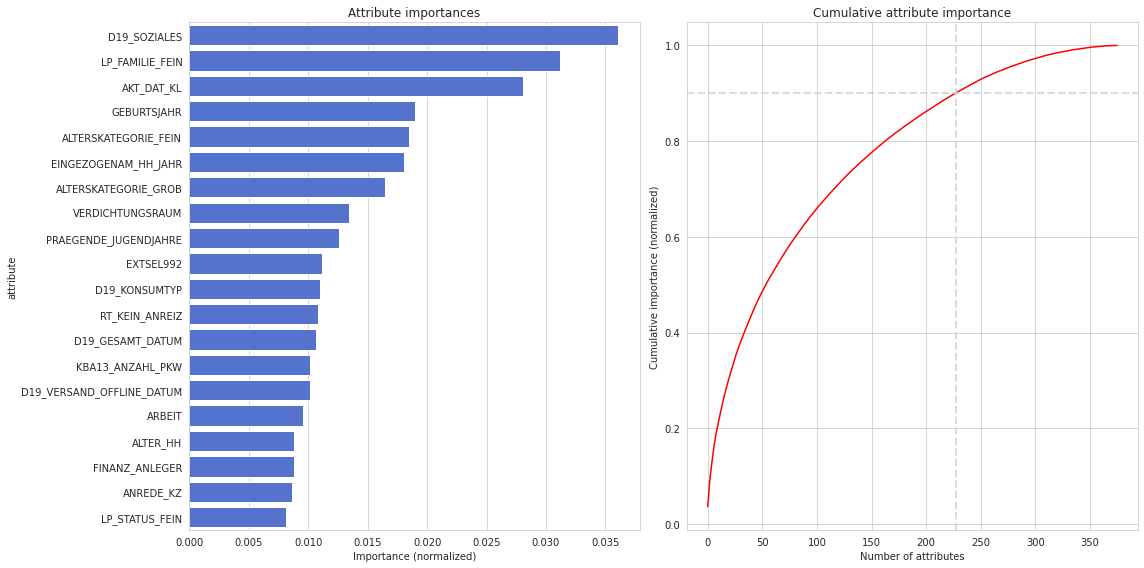

In [129]:
norm_attrib_imp = plot_attr_imp(attrib_imp)

In [130]:
# def plotImp(model, X , num = 20, fig_size = (40, 20)):
#     feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
#     plt.figure(figsize=fig_size)
#     sns.set(font_scale = 5)
#     sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
#                                                         ascending=False)[0:num])
#     plt.title('LightGBM Features (avg over folds)')
#     plt.tight_layout()
#     plt.savefig('lgbm_importances-01.png')
#     plt.show()

Let's remove the attributes, `zero_val_attrs` that have zero importance.

In [131]:
train.drop(columns=zero_val_attrs, inplace=True)

train.shape

(350000, 373)

In [132]:
def get_zero_imp_attrs(train, target, model_params, iters=2):
    """Compute zero importance attributes in a training dataset based on the 
    feature importances from a gradient boosting model (eg. LGBMClassifier). 
    
    Args:
        train (pd.DataFrame): Training features dataframe
        target (pd.Series): Labels for the training data
        model_params (dict): parameters for the classifier.
        iters (int): Number of cross validation splits to use for determining
            feature importances.
    
    Returns:
        zero_imp (list): Attributes with zero importance.
        importances (pd.DataFrame): Dataframe containing attributes with computed
            importances.
    """
    # Initialize an empty array to hold feature importances
    importances = np.zeros(train.shape[1])
    # Create the model with several hyperparameters
    clf = lgb.LGBMClassifier(**model_params)
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iters):
        # Split into training and validation set
        train_features, test_features, train_y, valid_y = \
        train_test_split(train, target, test_size=0.25, random_state=i)
        # Train using early stopping
        clf.fit(train_features, train_y,
                eval_metric='auc',
                eval_set=[(test_features, valid_y)], 
                early_stopping_rounds=100,
                verbose = 200)
        # Get feature importances
        importances += clf.feature_importances_ / iters
    
    importances = pd.DataFrame(
        {'attribute': list(train.columns), 'importance': importances}
        ).sort_values('importance', ascending=False)
    
    # Identify the attributes with zero importance
    zero_imp = importances[importances['importance'] == 0.0]['attribute'].tolist()
    print('\nNumber of attributes with zero importance: ', len(zero_imp))
    
    return zero_imp, importances

Having removed all zero importance attributes we identified, let us check once more the dataset for feature importance. We should not expect to have any more attributes with zero importance.

In [133]:
zero_val_attrs_ii, attrib_imp_ii = get_zero_imp_attrs(train, target, clf_params)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.934055	valid_0's binary_logloss: 0.32636
Early stopping, best iteration is:
[135]	valid_0's auc: 0.934344	valid_0's binary_logloss: 0.325826
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.934538	valid_0's binary_logloss: 0.324648
Early stopping, best iteration is:
[180]	valid_0's auc: 0.934594	valid_0's binary_logloss: 0.324583

Number of attributes with zero importance:  0


We will plot the results of this second operation increasing the threshold for cumulative importance value to `0.95`, to include a higher number of attributes.


273 features provide cumulative importance almost 0.95



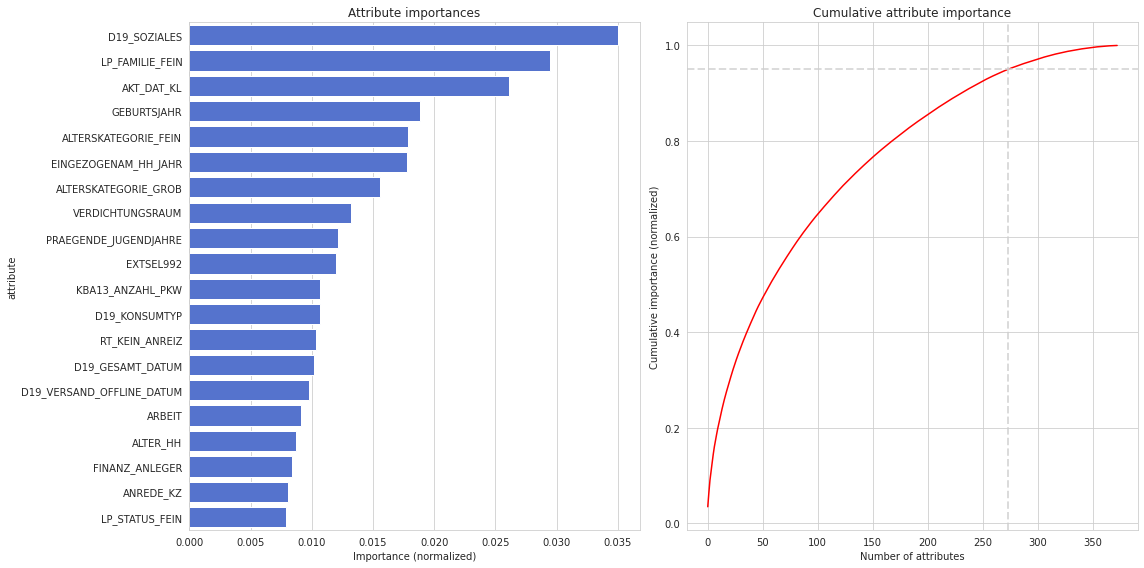

In [134]:
# Define cumulative importance threshold
cumul_imp_thres = .95

# Plot and get the normalized cumulative importances.
norm_attrib_imp_ii = plot_attr_imp(attrib_imp_ii, thres=cumul_imp_thres)

We will keep the `cumul_imp_thres` to `0.95` and create a list of attributes to keep, `attrs_to_keep`, based on this. We can then create an even smaller dataset.

In [135]:
# Extract the attributes to keep (the oners < .95 cumulative importance)
attrs_to_keep_ii = norm_attrib_imp_ii[norm_attrib_imp_ii['cumul_imp'] < cumul_imp_thres]['attribute'].tolist()

# Create new datasets with even less attributes than `train`.
train_ii = train[attrs_to_keep_ii]
# Add the `target` column.
train_ii = train_ii.assign(TARGET=target.values)
# Add the `LNR` column.
train_ii = train_ii.assign(LNR=clientIDs.values)

In [136]:
train_ii_file = '/content/drive/MyDrive/workspace/arvato_data/train_ii.csv' if IN_COLAB else 'train_ii.csv'
# Write to csv file.
train_ii.to_csv(train_ii_file, index=False)

So, from feature selection using gradient boosting model we may keep:

* `zero_val_attrs`, the list that contains all attributes identified with zero importance.
* `attrs_to_keep_ii`, a list that contains a smaller subset of non zero importance attributes reaching 0.95 cumulative importance.

We may test the above to other sample sub-sets. If it turns out that the feature selection works well we can also use the model above for making predictions in later steps.

For this we will create a couple more functions to help us through the steps.

In [140]:
def lgb_model(features_labels_split, cat_cols=None, n_folds=5):
    """Train and test a light gradient boosting model using
    cross validation with KFold splits. 
    
    Args:
        features_labels_split (list): List containing train-test split of inputs.
            Either [X_train, X_test, y_train, y_test] or [features, test_features]
            features will be pd.DataFrame of training features to use for training
            a model. Must include the `RESPONSE` column.
            test_features will be pd.DataFrame of testing features to use for
            making predictions with the model.
        cat_cols (None or np.array or list): An array containing categorical features.
        n_folds (int, default = 5): number of folds to use for cross validation.
        
    Returns:
        submission (pd.DataFrame): dataframe with `LNR` and `RESPONSE`
            probabilities predicted by the model.
        attrib_imp (pd.DataFrame): dataframe with the feature
            importances from the model.
        valid_metrics (pd.DataFrame): dataframe with training and validation
            metrics (ROC AUC) for each fold and overall.
    
    Ref: https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection#Remove-Collinear-Variables
    """
    # Differentiate assignments according to input (length=4 -> train_test_split)
    if len(features_labels_split) == 4:
        features, test_features, labels, test_labels = features_labels_split
        is_submission = False
    else:
        features, test_features = features_labels_split
        # Extract the labels for training
        labels = features['RESPONSE']
        is_submission = True
    
    # Extract the client IDs
    train_ids = features['LNR']
    test_ids = test_features['LNR']
    # Drop the client IDs and datetimes
    features.drop(columns=['LNR', 'EINGEFUEGT_AM', 'RESPONSE'], errors='ignore', inplace=True)
    test_features.drop(columns=['LNR', 'EINGEFUEGT_AM'], errors='ignore', inplace=True)
    
    # Specify the categorical features from supplied list else 'auto' define it.
    # cat_indices = np.intersect1d(features.columns.values, cat_cols) if cat_cols is not None else 'auto'
        
    print('\nTraining Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = features.columns.tolist()
    
    # Convert to np arrays
    features = features.to_numpy()
    test_features = test_features.to_numpy()
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Create the kfold object
    print("Creating KFold object")
    folds = KFold(n_splits=n_folds)
    
    # Lists for recording validation and training scores
    train_scores = []
    test_scores = []

    lgbm_params = {
        'boosting_type': 'goss',
        'learning_rate': 0.05,
        'n_estimators': 10000,
        'objective': 'binary',
        'class_weight': 'balanced',
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'random_state': 67,
        'n_jobs': -1,
    }

    print("\nStarting fold iterations")
    print(25*'-')
    # Iterate through folds
    for train_idx, val_idx in folds.split(features):
        # Training data for the fold
        fold_train_X, fold_train_y = features[train_idx], labels.iloc[train_idx] # (features[train_idx], labels.iloc[train_idx]) if not is_submission else (features[train_idx], labels[train_idx])
        # Validation data for the fold
        fold_test_X, fold_test_y = features[val_idx], labels.iloc[val_idx]  # (features[val_idx], labels.iloc[val_idx]) if not is_submission else (features[val_idx], labels[val_idx])
        # Create the model
        lgbm_clf = lgb.LGBMClassifier(**lgbm_params)
        # Train the model
        lgbm_clf.fit(
            fold_train_X, fold_train_y,
            eval_metric='auc',
            eval_set=[(fold_test_X, fold_test_y), (fold_train_X, fold_train_y)],
            eval_names=['test', 'train'],
            early_stopping_rounds=100,
            verbose = 200
        )
        # Keep the best iteration
        best_iter = lgbm_clf.best_iteration_
        # Extract and keep feature importances
        feature_importance_values += lgbm_clf.feature_importances_ / folds.n_splits
        # Make predictions using these importances
        test_predictions += lgbm_clf.predict_proba(test_features, num_iteration=best_iter)[:, 1] / folds.n_splits
        # Record the out of fold predictions
        out_of_fold[val_idx] = lgbm_clf.predict_proba(fold_test_X, num_iteration=best_iter)[:, 1]
        # Record the best score
        train_scores.append(lgbm_clf.best_score_['train']['auc'])
        test_scores.append(lgbm_clf.best_score_['test']['auc'])
        # Clean up memory
        del lgbm_clf, fold_train_X, fold_test_X, fold_train_y, fold_test_y
        gc.collect()

    print(25*'-')
    print("Creating output")    
    # Make the submission dataframe
    submission = pd.DataFrame({'LNR': test_ids, 'RESPONSE': test_predictions})
    
    # Make the feature importance dataframe
    attrib_imp = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    test_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    test_scores.append(test_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'test': test_scores}) 
    
    return submission, attrib_imp, metrics

In [124]:
# Add the `LNR` column.
train = train.assign(LNR=clientIDs.values)

submit_i, attrib_imp_i, metrics_i = lgb_model(train_test_split(train, target, stratify=target, test_size=.25))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,



Training Data Shape:  (262500, 372)
Testing Data Shape:  (87500, 372)
Creating KFold object

Starting fold iterations
-------------------------
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.939956	train's binary_logloss: 0.313164	test's auc: 0.936076	test's binary_logloss: 0.321932
[400]	train's auc: 0.946835	train's binary_logloss: 0.296843	test's auc: 0.936843	test's binary_logloss: 0.319634
Early stopping, best iteration is:
[409]	train's auc: 0.94707	train's binary_logloss: 0.296235	test's auc: 0.936914	test's binary_logloss: 0.319521
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.940778	train's binary_logloss: 0.311296	test's auc: 0.933203	test's binary_logloss: 0.328089
[400]	train's auc: 0.94749	train's binary_logloss: 0.295064	test's auc: 0.933923	test's binary_logloss: 0.326161
Early stopping, best iteration is:
[364]	train's auc: 0.946405	train's binary_logloss: 0.297629	test's auc: 0.933954	test's bi

In [125]:
metrics_i

,fold,train,test
0,0,0.947070,0.936914
1,1,0.946405,0.933954
2,2,0.950649,0.934106
3,3,0.947212,0.935600
4,4,0.949676,0.936690
5,overall,0.948202,0.935415


In [ ]:
# Clean up memory
# del train, target
# gc.collect()

In [150]:
# Test the smaller dataset with 0.95 features to keep
target_ii = train_ii['TARGET']
train_ii = train_ii.drop(columns=['TARGET'])

submit_ii, attrib_imp_ii, metrics_ii = lgb_model(train_test_split(train_ii, target_ii, stratify=target_ii, test_size=.25))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,



Training Data Shape:  (262500, 273)
Testing Data Shape:  (87500, 273)
Creating KFold object

Starting fold iterations
-------------------------
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.940344	train's binary_logloss: 0.312394	test's auc: 0.936696	test's binary_logloss: 0.320446
[400]	train's auc: 0.947038	train's binary_logloss: 0.296107	test's auc: 0.937402	test's binary_logloss: 0.318321
[600]	train's auc: 0.952429	train's binary_logloss: 0.282769	test's auc: 0.937466	test's binary_logloss: 0.317689
Early stopping, best iteration is:
[509]	train's auc: 0.950096	train's binary_logloss: 0.288604	test's auc: 0.937584	test's binary_logloss: 0.317671
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.940613	train's binary_logloss: 0.311527	test's auc: 0.934979	test's binary_logloss: 0.32442
[400]	train's auc: 0.947227	train's binary_logloss: 0.29561	test's auc: 0.935531	test's binary_logloss: 0.322643
Early stoppi

In [151]:
metrics_ii

,fold,train,test
0,0,0.950096,0.937584
1,1,0.949419,0.935651
2,2,0.949841,0.935481
3,3,0.949679,0.935345
4,4,0.945635,0.934140
5,overall,0.948934,0.935579


In [ ]:
# Clean up memory
# del train_ii, target_ii
# gc.collect()

We can observe that using 273 attributes (selected using features importance) or 0.95 cumulative feature importance can provide almost the same results as when testing with 372 attributes or 1.0 cumulative features importance.

In [157]:
def create_train_test(dfs, read_csv_kwargs, wrangle_args, train_test_args):
    """Get sample data from two similar demographic type datesets. One dataset
    contains verified entries while the other not. `Target` columns are created
    and added to the datasets which concatanated and cleaned. Returns train,
    target sets split.

    Args:
        dfs (dict): dictionary of the form: {'filename': 'sample_size'}
        read_csv_kwargs (dict): `read_csv` parameters dictionary
        wrangle_args (tuple): `wrangle_df` function parameters tuple
        train_test_args (dict): scikit's `train_test_split` parameters dictionary

    Returns:
        List containing train-test split of concatenated input dataframes. (As
        in https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    """
    # 1. Read samples and wrangle data
    df_s = {}
    for k in dfs:
        print("Loading samples from [" + k.upper() + "]")
        df_s[k] = get_df_sample(dfs[k][1], None, dfs[k][0], **read_csv_kwargs)
        # df_s[k] = wrangle_df(df_s[k], *wrangle_args)
        
    # 2. Create a new df concatenating the dfs also creating a `target` attribute "customer"
    df_ = pd.concat([df_s[k].assign(RESPONSE=1 if k == 'customers' else 0) for k in df_s])
    df_ = wrangle_df(df_, *wrangle_args)
    print(25*"-")

    # 3. One-hot encoding
    # df_ = pd.get_dummies(df_)

    # 4. Create train, target
    X = df_.drop(columns="RESPONSE")
    y = df_["RESPONSE"]

    # Split into training and larger test sets (data will be shuffled by default)
    return train_test_split(X, y, stratify=y, **train_test_args)

# dfs dictionary of the form: {'filename': 'sample_size'}, use 4:1 azdias:customers
dfs_comb = {
    'azdias': (azdias_file, 400000),
    'customers': (customers_file, 100000),
}

# `read_csv` parameters dictionary (use the one from the begining of notebook)

# `wrangle_df` parameters tuple
wrangle_args = [
    attrs_val_pools,
    attrs_common,
    replace9_nan_dict,
    zero_val_attrs
]
# wrangle_args = (attrs_val_pools, attrs_common, replace9_nan_dict)

# `train_test_split` parameters dictionary
train_test_args = {
    'test_size': .25,
    'random_state': 67,
}

In [ ]:
# Get an initial train-test split 75-25.
# X_train, X_test, y_train, y_test = create_train_test(dfs_comb, read_csv_kwargs, wrangle_args, train_test_args)
# train_test_dfs = create_train_test(dfs_comb, read_csv_kwargs, wrangle_args)

In [ ]:
# submit, attrib_imp, metrics = lgb_model(create_train_test(dfs_comb, read_csv_kwargs, wrangle_args, train_test_args), cat_attrs)
submit, attrib_imp, metrics = lgb_model(create_train_test(dfs_comb, read_csv_kwargs, wrangle_args, train_test_args))

Dataframe [AZDIAS]
-------------------------
Dataframe [CUSTOMERS]
-------------------------
Total df NaNs portion:  0.2991
Column NaNs:
Average NaNs per column:  0.2991
Max NaNs per column:  0.9991
Min NaNs per column:  0.0
Row NaNs:
Average NaNs per row:  0.2991
Max NaNs per row:  0.8568
Min NaNs per row:  0.0676
Training Data Shape:  (375000, 414)
Testing Data Shape:  (125000, 414)
Creating KFold object

Starting fold iterations
-------------------------
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.309627	train's auc: 0.941341	test's binary_logloss: 0.323476	test's auc: 0.934835
Early stopping, best iteration is:
[291]	train's binary_logloss: 0.301538	train's auc: 0.944707	test's binary_logloss: 0.321153	test's auc: 0.935277
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.310373	train's auc: 0.94107	test's binary_logloss: 0.321067	test's auc: 0.935676
Early stopping, best iteration is:
[

In [ ]:
metrics

,fold,train,test
0,0,0.944707,0.935277
1,1,0.944542,0.936141
2,2,0.948661,0.935984
3,3,0.949549,0.935476
4,4,0.951411,0.935166
5,overall,0.947774,0.935556


In [ ]:
attrib_imp.sort_values(by='importance', ascending=False).tail(15)

,feature,importance
357,CAMEO_DEU_2015_6A,1.2
356,CAMEO_DEU_2015_5F,1.0
391,D19_LETZTER_KAUF_BRANCHE_D19_HANDWERK,1.0
386,D19_LETZTER_KAUF_BRANCHE_D19_DIGIT_SERV,1.0
377,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_DIREKT,0.8
374,CAMEO_DEU_2015_9C,0.8
343,CAMEO_DEU_2015_3B,0.6
393,D19_LETZTER_KAUF_BRANCHE_D19_KINDERARTIKEL,0.6
342,CAMEO_DEU_2015_3A,0.6
403,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,0.4


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [164]:
# mailout_train = pd.read_csv(mailout_train_file, sep=';')
mailout_train = pd.read_csv(mailout_train_file, sep=';', na_values=na_tupl, parse_dates=['EINGEFUEGT_AM'])
mailout_train.shape

(42962, 367)

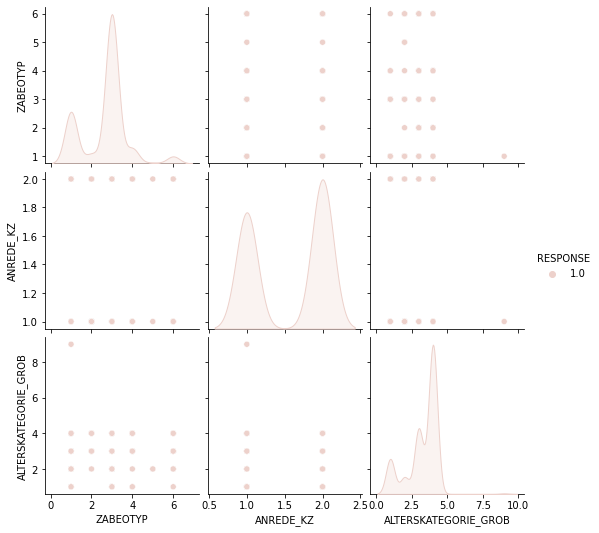

In [128]:
# sns.pairplot(mailout_train.iloc[:, -4:], hue='RESPONSE')

In [142]:
mailout_train.dtypes.value_counts()

float64           321
int64              42
object              3
datetime64[ns]      1
dtype: int64

In [129]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,NaN,NaN,1.0,13.0,NaN,3.0,5.0,5D,5.0,34.0,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,NaN,NaN,...,5.0,5.0,2.0,5.0,1.0,6,7,2,6,6,1,7,1,3,2,1,5,1,3,3.0,NaN,3.0,NaN,2.0,4.0,NaN,4.0,2.0,1.0,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,NaN,2,4
1,1771,1.0,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,NaN,NaN,2.0,1.0,NaN,2.0,5.0,5B,5.0,32.0,2.0,2.0,2.0,2.0,4.0,3.0,5.0,4.0,1.0,1.0,5,NaN,NaN,3.0,10,10,NaN,NaN,NaN,6.0,...,1.0,2.0,3.0,1.0,3.0,6,6,1,5,6,3,6,5,5,4,3,1,3,4,2.0,NaN,1.0,NaN,2.0,5.0,NaN,NaN,1.0,1.0,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,NaN,2,3
2,1776,1.0,1.0,9.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,1.0,NaN,4.0,1.0,2D,2.0,14.0,4.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,NaN,1.0,7,NaN,NaN,NaN,10,7,NaN,5.0,NaN,NaN,...,4.0,3.0,1.0,5.0,2.0,3,3,4,1,3,4,7,6,1,1,5,3,1,7,3.0,NaN,3.0,NaN,1.0,5.0,NaN,10.0,1.0,4.0,1.0,6.0,4.0,2.0,NaN,9.0,2.0,3,NaN,1,4
3,1460,2.0,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,NaN,NaN,2.0,4.0,NaN,4.0,2.0,2D,2.0,14.0,2.0,5.0,2.0,2.0,5.0,5.0,5.0,4.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,NaN,6.0,...,3.0,5.0,2.0,5.0,1.0,5,7,1,6,7,1,7,1,4,2,2,5,3,2,1.0,NaN,3.0,NaN,3.0,5.0,NaN,5.0,2.0,1.0,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,NaN,2,4
4,1783,2.0,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,NaN,NaN,1.0,44.0,NaN,3.0,4.0,7B,7.0,41.0,6.0,5.0,1.0,2.0,5.0,5.0,5.0,5.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,5.0,NaN,...,3.0,5.0,1.0,5.0,1.0,5,4,6,2,5,5,6,6,4,5,4,6,2,7,1.0,NaN,3.0,NaN,2.0,5.0,NaN,4.0,1.0,NaN,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,NaN,1,3


In [154]:
y = mailout_train['RESPONSE']
X = mailout_train.drop(columns=['LNR', 'RESPONSE', 'EINGEFUEGT_AM'])

In [131]:
y.value_counts(dropna=False)

NaN    42430
1.0      532
Name: RESPONSE, dtype: int64

We see that there is a large class **imbalance** in the dataset. There are a lot of individuals that did not respond to the mail campaign.

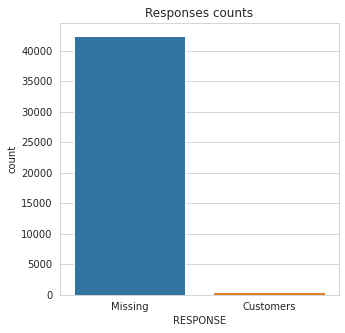

In [132]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(5,5))
    ax1 = sns.countplot(x=y.fillna(-1))
    ax1.set(xticks=range(2),
            xticklabels=['Missing', 'Customers'],
            title='Responses counts')

In [155]:
X = wrangle_df(X, *wrangle_args)
X = pd.get_dummies(X)

X.shape

Total df NaNs portion:  0.3064
Column NaNs:
Average NaNs per column:  0.3064
Max NaNs per column:  0.9991
Min NaNs per column:  0.0
Row NaNs:
Average NaNs per row:  0.3064
Max NaNs per row:  0.8462
Min NaNs per row:  0.0714


(42962, 402)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [180]:
def kaggle_submit(filename, message, competition, data):
    """Prepare data, export to csv file and submit to kaggle competition.
    Args:
        filename (srt): name of the csv file to submit and write to
        message (srt): message related to submission
        competition (srt): the name of kaggle competition to submit 
        data (pd.DataFrame): submission dataframe of the form e.g.
        {"LNR": pd.Series, "RESPONSE": pd.Series}
    Returns:
        (str): Submission request response
    """
    # kaggle competition: udacity-arvato-identify-customers
    # Kaggle competition invitation: http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140
    kg_api = KaggleApi()
    kg_api.authenticate()

    data.to_csv(filename, index=False)

    return kg_api.competition_submit(filename, message, competition)

# kaggle_submit(kg_submission + "lgbm_test.csv", kg_competition, 'lgbm 1st submission', data)

In [165]:
#mailout_test = pd.read_csv(mailout_test_file, sep=';') 
mailout_test = pd.read_csv(mailout_test_file, sep=';', na_values=na_tupl, parse_dates=['EINGEFUEGT_AM'])
mailout_test.shape

(42833, 366)

In [166]:
# Hold RESPONSE values separately
target_mailout = mailout_train['RESPONSE'].fillna(-1)
mailout_train.drop(columns=['RESPONSE'], inplace=True)

mailout_train.shape

(42962, 366)

In [167]:
# Clean - fix both datasets.
mailout_train = wrangle_df(mailout_train, *wrangle_args)
mailout_test = wrangle_df(mailout_test, *wrangle_args)

mailout_train.shape, mailout_test.shape

Total df NaNs portion:  0.3064
Column NaNs:
Average NaNs per column:  0.3064
Max NaNs per column:  0.9991
Min NaNs per column:  0.0
Row NaNs:
Average NaNs per row:  0.3064
Max NaNs per row:  0.8462
Min NaNs per row:  0.0714
Total df NaNs portion:  0.3048
Column NaNs:
Average NaNs per column:  0.3048
Max NaNs per column:  0.9991
Min NaNs per column:  0.0
Row NaNs:
Average NaNs per row:  0.3048
Max NaNs per row:  0.8599
Min NaNs per row:  0.0742


In [169]:
# Put the RESPONSE column back in the train set.
mailout_train = mailout_train.assign(RESPONSE=target_mailout.values)

mailout_train.shape, mailout_test.shape

((42962, 374), (42833, 373))

In [181]:
# Check there are no NaNs and no infinites
np.any(np.isnan(mailout_test)), np.all(np.isfinite(mailout_test))

(False, True)

In [174]:
# Run the model
submit_kg, attrib_imp_kg, metrics_kg = lgb_model([mailout_train, mailout_test])


Training Data Shape:  (42962, 372)
Testing Data Shape:  (42833, 372)
Creating KFold object

Starting fold iterations
-------------------------
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[22]	train's auc: 0.919237	train's binary_logloss: 0.46447	test's auc: 0.73748	test's binary_logloss: 0.490246
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[29]	train's auc: 0.934931	train's binary_logloss: 0.432102	test's auc: 0.762564	test's binary_logloss: 0.469827
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[14]	train's auc: 0.882147	train's binary_logloss: 0.527281	test's auc: 0.785709	test's binary_logloss: 0.537272
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[52]	train's auc: 0.961309	train's binary_logloss: 0.351395	test's auc: 0.76429	test's binary_logloss: 0.389077
Training until 

In [175]:
metrics_kg

,fold,train,test
0,0,0.919237,0.737480
1,1,0.934931,0.762564
2,2,0.882147,0.785709
3,3,0.961309,0.764290
4,4,0.868793,0.757325
5,overall,0.913284,0.757234


In [178]:
attrib_imp_kg.sort_values(by='importance', ascending=False).head()

,feature,importance
40,D19_SOZIALES,51.0
57,EINGEZOGENAM_HH_JAHR,21.6
137,KBA13_ALTERHALTER_30,13.8
145,KBA13_ANZAHL_PKW,11.4
70,GEBURTSJAHR,10.2


In [182]:
# Submit to Kaggle competition
msg = 'LightGBM [31 leaves, -1 depth] all mailout data'
kaggle_submit(kg_submission + "lgbm_test.csv", kg_competition, msg, submit_kg)

ApiException: ignored